In [1]:
import numpy as np
from numpy import trapz
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.stats import bootstrap
from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky


from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
#from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc,flux_to_mag
import pymoc
from pymoc.io.fits import read_moc_fits

from astropy.io import registry
from astropy.table.info import serialize_method_as
import statsmodels.duration.survfunc as survfunc

In [2]:
plt.rcParams['font.size']=10

In [3]:
def calistro_fit(z):
    law = 1.72*(1+z)**(-0.22)
    return(law)

In [4]:
def delhaize_fit(z):
    law = 2.88*(1+z)**(-0.19) + np.log10((1400/150)**(-0.78))
    return(law)

In [5]:
def delvecchio_mstar_evo(mstar):
    q = 2.586 - 0.124*(mstar-10) + np.log10((1400/150)**(-0.58))
    return(q)

In [6]:
delvecchio_mstar_evo(10.5)

1.961378669558917

In [7]:
def get_center(bins):
    centers = (bins[:-1] + bins[1:])/2
    return(centers)

In [8]:
def power_law(x,N,a):
    y = N * (1+x)**a
    return(y)

In [9]:
def linear_fit(x,m,c):
    y = m*x + c
    return(y)

In [10]:
def fit_func(x,a,b,c):
    y = 1/(b*x**a) + c
    return(y)

In [11]:
def create_sf_mask(NUV,r,j):
    #creates a mask to select SF galaxies based on the criteria from Davidzon et al 2017
    NUV_r = NUV - r
    r_j = r-j
    mask = (NUV_r>3.1) & ((NUV_r - 3*r_j) > 1)
    return(~mask)

In [12]:
def create_ssfr_mask(z,ssfr):
    #create a mask to select SF galaxies based on their distance to the main sequence
    #any galaxy less that 0.3 dex below the main sequnce is counted as a SF galaxy
    # main sequnce equation taken from Sargent et al 2012
    main_sequnce = np.log10(power_law(z,1,2.8)) - np.log10(5E10) - 0.3

    mask = ssfr>=main_sequnce
    
    return(mask)

In [13]:
def return_fir_detected_mask(cat):
    
    FIR_col_names = ['F_PACS_100','F_PACS_160','F_SPIRE_250','F_SPIRE_350','F_SPIRE_500']
    FIR_flag_col_names = ['flag_PACS_100','flag_PACS_160','flag_spire_250','flag_spire_350','flag_spire_500']
    
    num_fir_bands_not_detected = np.zeros(len(cat))
    
    for n in range(len(FIR_col_names)):
        mask_tmp = (np.isnan(cat[FIR_col_names[n]])) | (cat[FIR_flag_col_names[n]])
        
        num_fir_bands_not_detected = num_fir_bands_not_detected + mask_tmp.astype(int)
        
    mask_fir_detected = num_fir_bands_not_detected <= 3
    
    return(mask_fir_detected)

In [14]:
def main_sequnce_calc_schreiber2015(mass,redshift):
    
    #calculates the expected SFR of a galaxy from it's stellar mass and redshift using the best fit relation from 
    #Schreiber2015
    
    #Inputs:
    #mass in stellar masses
    #redshift
    
    m = np.log10(mass/1E9)
    m0 = 0.5
    m1 = 0.36
    r = np.log10(1+redshift)
    a0 = 1.5
    a1 = 0.3
    a2 = 2.5
    
    max_term = m-m1-a2*r
    mask = max_term<0
    max_term[mask] = 0
    
    SFR = m - m0 + a0*r - a1*(max_term)**2
    return(SFR)

In [15]:
def main_sequence_calc_leslie2020(mass,redshift):
    
    #calculates the expected SFR of a galaxy from it's stellar mass and redshift using the best fit relation from 
    #Leslie2020
    
    #Inputs:
    #mass in stellar masses
    #redshift
    
    t = cosmo.age(redshift).to(u.Gyr).value
    
    s0 = 2.97
    a1 = 0.22
    a2 = 0.12
    M0 = 11.06
    Mt = M0 - a2*t
    
    SFR = s0 - a1*t - np.log10(1 + (10**Mt/10**mass))
    return(SFR)

In [16]:
lofar_sed_en1 = Table.read('../lofar/data/lofar_sed_en1.fits')
print(len(lofar_sed_en1))
lofar_sed_en1[0]

31610


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,radio_luminosity,q_magphys,q_agnfitter,q_250,q_350,q_500,radio_flux_pixel,radio_flux_err_pixel,radio_luminosity_pixel,q_pixel,Radio_ID,Spitzer_SN,Donley,Lacy,Stern,Messias,KI,Ch2_Ch4,Ch4_24mu,Xray,Opt_spec,AGNfrac_af,AGNfrac_af_16,AGNfrac_cg_s,AGNfrac_cg_s_16,AGNfrac_cg_f,AGNfrac_cg_f_16,Chi_sq_MpBp,Chi_sq_AfCg,AGN_final,Mass_conc,SFR_conc,Radio_excess,Radio_excess_DJS,Exte

In [17]:
lofar_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/data_release/final_cross_match_catalogue-v1.0.fits')
print(len(lofar_en1))
lofar_en1[0]

31610


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,f

In [18]:
print(np.sum(np.isnan(lofar_en1['F_PACS_100'])))

mask = lofar_en1['ch1_swire_flux_corr']>10
print(sum(mask))
print(sum(lofar_en1['Z_BEST']<1.0))
mask = (lofar_en1['ch1_swire_flux_corr']>10) & (lofar_en1['Z_BEST']<1.0)
print(sum(mask))

18
28151
15230
15083


In [19]:
lofar_magphys_en1 = Table.read('../lofar/data/magphys_mass_radio_limits_en1.fits')
#mask = lofar_magphys_en1['q_lim']==1E20
#lofar_magphys_en1['q_lim'][mask] = np.nan
print(len(lofar_magphys_en1))
lofar_magphys_en1[0]

146949


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim,q_250_lim,q_350_lim,q_500_lim
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag

In [20]:
dist = cosmo.luminosity_distance(lofar_magphys_en1['Z_BEST']).to(u.m).value
lir_flux = lofar_magphys_en1['Ldust_bayes']/(4*np.pi*dist*dist)
col_lir_flux = Column(name='TIR_flux',data=lir_flux)
lofar_magphys_en1.add_column(col_lir_flux)

dist = cosmo.luminosity_distance(lofar_sed_en1['Z_BEST']).to(u.m).value
lir_flux = lofar_sed_en1['Ldust_bayes']/(4*np.pi*dist*dist)
col_lir_flux = Column(name='TIR_flux',data=lir_flux)
lofar_sed_en1.add_column(col_lir_flux)

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


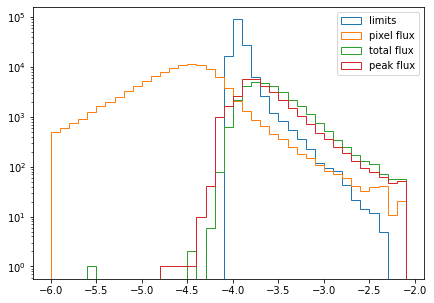

In [21]:
plt.figure(figsize=[7,5])

bins= np.arange(-6,-2,0.1)
y = np.log10(lofar_magphys_en1['radio_flux_limit'])
plt.hist(y,bins=bins,log=True,histtype='step',label='limits')

y = np.log10(lofar_magphys_en1['radio_flux_pixel'])
plt.hist(y,bins=bins,log=True,histtype='step',label='pixel flux')

y = np.log10(lofar_sed_en1['Total_flux'])
plt.hist(y,bins=bins,log=True,histtype='step',label='total flux')

y = np.log10(lofar_sed_en1['Peak_flux'])
plt.hist(y,bins=bins,log=True,histtype='step',label='peak flux')

plt.legend()
plt.show()

In [22]:
stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

mask = (stellar_mass_cat['Z_BEST']<1.0) & (stellar_mass_cat['Mass_median']>10.45)
print('there are {} sources with M>10.7 and z<1.0'.format(np.sum(mask)))

there are 50388 sources with M>10.7 and z<1.0


In [23]:
mask = (stellar_mass_cat['Z_BEST']<0.4) & (stellar_mass_cat['Mass_median']>10.05)
print('there are {} sources with M>10.7 and z<1.0'.format(np.sum(mask)))

there are 14674 sources with M>10.7 and z<1.0


In [24]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc

print('There are {} galaxies detected in the radio with a stellar mass>10.45 and z<1'.format(np.sum(mask_mass_complete_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.45 and z<1'.format(np.sum(mask_mass_complete_limit_en1)))

There are 10046 galaxies detected in the radio with a stellar mass>10.45 and z<1
There are 41763 galaxies with only a Ldust measurement with a stellar mass>10.45 and z<1


In [25]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc

print('There are {} galaxies detected in the radio with a stellar mass>10.05 and z<0.4'.format(np.sum(mask_mass_complete_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.05 and z<0.4'.format(np.sum(mask_mass_complete_limit_en1)))

There are 3464 galaxies detected in the radio with a stellar mass>10.05 and z<0.4
There are 10447 galaxies with only a Ldust measurement with a stellar mass>10.05 and z<0.4


In [26]:
#create a mask to select a sample to test for redshift evolution at z<1

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
#SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],(np.log10(lofar_sed_en1['SFR_bayes']) - mstar))
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
#SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],(np.log10(lofar_magphys_en1['SFR_bayes']) - mstar))
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

There are 7678 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 14944 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


In [27]:
#create a mask to select a sample to test for redshift evolution at z<1

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
#SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],(np.log10(lofar_sed_en1['SFR_bayes']) - mstar))
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
#mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
#SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],(np.log10(lofar_magphys_en1['SFR_bayes']) - mstar))
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

There are 2695 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 3100 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


In [38]:
ldust = limit_sample_en1['Ldust_bayes']
lrad = 10**(np.log10(ldust/3.75E12) - 1.7)

alpha = -0.6
z = limit_sample_en1['Z_BEST']
dist = cosmo.luminosity_distance(z).to(u.m).value
frad = lrad/(4*np.pi*dist**2 * 1E-26 * (1+z)**(-1-alpha))
np.sum(frad>1E-4)

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


2419

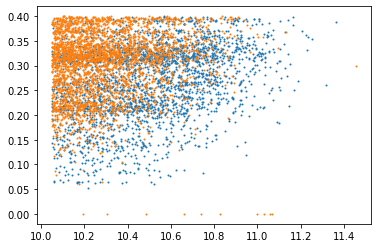

In [39]:
x = np.log10(detected_sample_en1['Mstar_bayes']/3.8E26)
y = detected_sample_en1['Z_BEST']
plt.scatter(x,y,s=1)

x = np.log10(limit_sample_en1['Mstar_bayes']/3.8E26)
y = limit_sample_en1['Z_BEST']
plt.scatter(x,y,s=1)

## Distribution fo galaxies with a radio detection or upper limit and split by whether they have >1 FIR detection

There are 7678 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 14944 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
There are 2695 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 3100 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


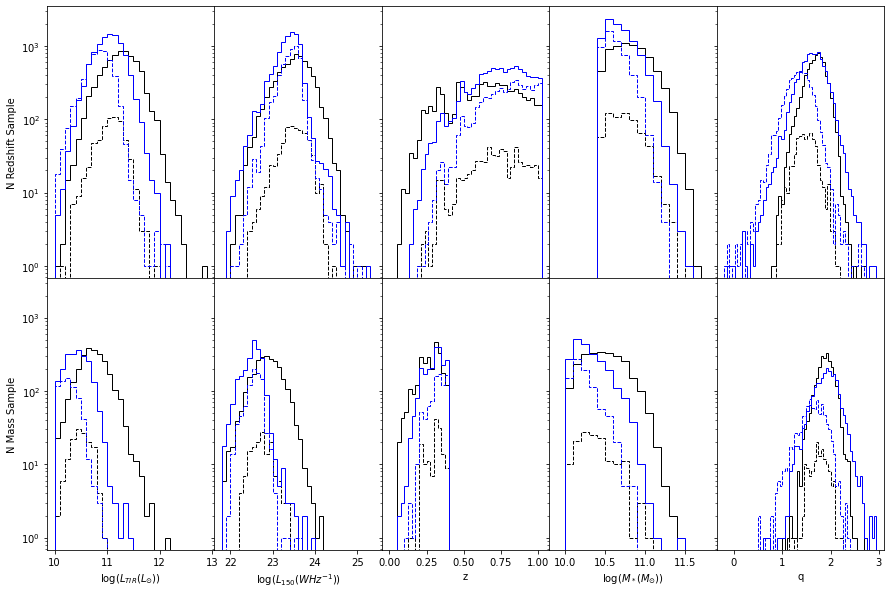

In [263]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],(np.log10(lofar_sed_en1['SFR_bayes']) - mstar))
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],(np.log10(lofar_magphys_en1['SFR_bayes']) - mstar))
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))



agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1[~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]


limit_data = limit_sample_en1
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]

fig,axs = plt.subplots(2,5,figsize=[15,10],sharey=True)


mask_fir_det = return_fir_detected_mask(detected_data)
mask_fir_lim = return_fir_detected_mask(limit_data)

bins = np.arange(10,13,0.1)
y = np.log10(detected_data['Ldust_bayes'][~mask_fir_det]/3.8E26)
axs[0][0].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = np.log10(detected_data['Ldust_bayes'][mask_fir_det]/3.8E26)
axs[0][0].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = np.log10(limit_data['Ldust_bayes'][~mask_fir_lim]/3.8E26)
axs[0][0].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = np.log10(limit_data['Ldust_bayes'][mask_fir_lim]/3.8E26)
axs[0][0].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')


bins = np.arange(21.8,25.5,0.1)
y = np.log10(detected_data['radio_luminosity'][~mask_fir_det])
axs[0][1].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = np.log10(detected_data['radio_luminosity'][mask_fir_det])
axs[0][1].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = np.log10(limit_data['radio_luminosity_limit'][~mask_fir_lim])
axs[0][1].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = np.log10(limit_data['radio_luminosity_limit'][mask_fir_lim])
axs[0][1].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')


bins = np.arange(0,1,0.025)
y = detected_data['Z_BEST'][~mask_fir_det]
axs[0][2].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = detected_data['Z_BEST'][mask_fir_det]
axs[0][2].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = limit_data['Z_BEST'][~mask_fir_lim]
axs[0][2].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = limit_data['Z_BEST'][mask_fir_lim]
axs[0][2].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')


bins = np.arange(9.9,11.8,0.1)
y = np.log10(detected_data['Mstar_bayes'][~mask_fir_det]/3.8E26)
axs[0][3].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = np.log10(detected_data['Mstar_bayes'][mask_fir_det]/3.8E26)
axs[0][3].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = np.log10(limit_data['Mstar_bayes'][~mask_fir_lim]/3.8E26)
axs[0][3].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = np.log10(limit_data['Mstar_bayes'][mask_fir_lim]/3.8E26)
axs[0][3].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')


bins = np.arange(0,3,0.05)
y = detected_data['q_magphys'][~mask_fir_det]
axs[0][4].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = detected_data['q_magphys'][mask_fir_det]
axs[0][4].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = limit_data['q_lim'][~mask_fir_lim]
axs[0][4].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = limit_data['q_lim'][mask_fir_lim]
axs[0][4].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')

#mass sample
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

#create a mask to select a sample to test for redshift evolution at z<1

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],(np.log10(lofar_sed_en1['SFR_bayes']) - mstar))
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],(np.log10(lofar_magphys_en1['SFR_bayes']) - mstar))
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1[~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]


limit_data = limit_sample_en1
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]

mask_fir_det = return_fir_detected_mask(detected_data)
mask_fir_lim = return_fir_detected_mask(limit_data)

bins = np.arange(10,13,0.1)
y = np.log10(detected_data['Ldust_bayes'][~mask_fir_det]/3.8E26)
axs[1][0].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = np.log10(detected_data['Ldust_bayes'][mask_fir_det]/3.8E26)
axs[1][0].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = np.log10(limit_data['Ldust_bayes'][~mask_fir_lim]/3.8E26)
axs[1][0].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = np.log10(limit_data['Ldust_bayes'][mask_fir_lim]/3.8E26)
axs[1][0].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')

axs[1][0].set_xlabel('$\log( L_{TIR}(L_{\odot}) )$')


bins = np.arange(21.8,25.5,0.1)
y = np.log10(detected_data['radio_luminosity'][~mask_fir_det])
axs[1][1].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = np.log10(detected_data['radio_luminosity'][mask_fir_det])
axs[1][1].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = np.log10(limit_data['radio_luminosity_limit'][~mask_fir_lim])
axs[1][1].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = np.log10(limit_data['radio_luminosity_limit'][mask_fir_lim])
axs[1][1].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')

axs[1][1].set_xlabel('$\log( L_{150}(W Hz^{-1}) )$')


bins = np.arange(0,1.05,0.025)
y = detected_data['Z_BEST'][~mask_fir_det]
axs[1][2].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = detected_data['Z_BEST'][mask_fir_det]
axs[1][2].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = limit_data['Z_BEST'][~mask_fir_lim]
axs[1][2].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = limit_data['Z_BEST'][mask_fir_lim]
axs[1][2].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')

axs[1][2].set_xlabel('z')


bins = np.arange(9.9,11.8,0.1)
y = np.log10(detected_data['Mstar_bayes'][~mask_fir_det]/3.8E26)
axs[1][3].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = np.log10(detected_data['Mstar_bayes'][mask_fir_det]/3.8E26)
axs[1][3].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = np.log10(limit_data['Mstar_bayes'][~mask_fir_lim]/3.8E26)
axs[1][3].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = np.log10(limit_data['Mstar_bayes'][mask_fir_lim]/3.8E26)
axs[1][3].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')

axs[1][3].set_xlabel('$\log( M_*(M_{\odot}) )$')


bins = np.arange(-0.2,3,0.05)
y = detected_data['q_magphys'][~mask_fir_det]
axs[1][4].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='black')
y = detected_data['q_magphys'][mask_fir_det]
axs[1][4].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='black')

y = limit_data['q_lim'][~mask_fir_lim]
axs[1][4].hist(y,bins=bins,log=True,histtype='step',linestyle='dashed',color='blue')
y = limit_data['q_lim'][mask_fir_lim]
axs[1][4].hist(y,bins=bins,log=True,histtype='step',linestyle='solid',color='blue')

axs[1][4].set_xlabel('q')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
axs[0][0].set_ylabel('N Redshift Sample')
axs[1][0].set_ylabel('N Mass Sample')
plt.savefig('plots/param_distribution.pdf',format='pdf')
plt.show()

There are 7678 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 14944 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
q = 1.9092678695569272 +/- 0.003063315302122128
where the error is the standard error of the bootstrapped medians


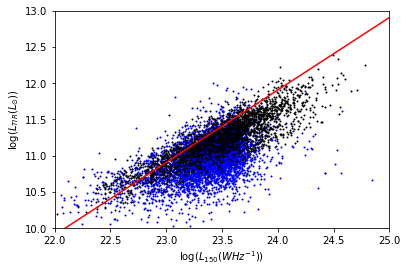

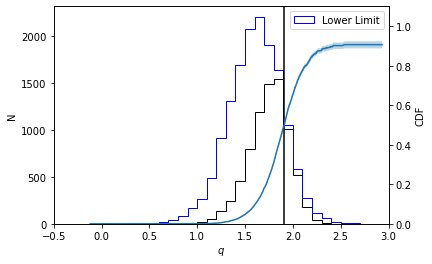

In [79]:
#create a mask to select a sample to test for redshift evolution at z<1

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
#SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],(np.log10(lofar_sed_en1['SFR_bayes']) - mstar))
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
#SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],(np.log10(lofar_magphys_en1['SFR_bayes']) - mstar))
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1[det_name][~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
ldust_det = detected_sample_en1[ldust_name][~agn_mask][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))


n_bootstrap = 10
n_samples_data = int(len(data)*0.9)
bootstrap_data = bootstrap(np.arange(0,len(data),1),n_bootstrap,n_samples_data).astype(int)

medians = []
errs = []
for n,nums in enumerate(bootstrap_data):
    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data[bootstrap_data[n]], det[bootstrap_data[n]],label='Kaplan Meier Estimate')

    ## Create an estimate

    x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    x = np.arange(-1,3,0.01)
    lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
    upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

    err = upx-lowx
    medians.append(kmf.median_survival_time_)
    errs.append(err)
print('q = {} +/- {}'.format(np.mean(medians),np.std(medians)))
print('where the error is the standard error of the bootstrapped medians')






sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

'''mask_fir_det = return_fir_detected_mask(limit_sample_en1)
y = np.log10(limit_sample_en1[ldust_lim_name][mask_fir_det][::3]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name][mask_fir_det][::3])
plt.scatter(x,y,s=1,label='Lower Limits',c='cyan')'''

y = np.log10(limit_sample_en1[ldust_lim_name][::3]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name][::3])
plt.scatter(x,y,s=1,label='Lower Limits',c='blue')


'''mask_fir_det = return_fir_detected_mask(detected_sample_en1)
x = np.log10(detected_sample_en1[rad_name][mask_fir_det & ~agn_mask][::3])
y = np.log10(detected_sample_en1[ldust_name][mask_fir_det & ~agn_mask][::3]/3.8E26)
plt.scatter(x,y,s=1,c='red')'''

x = np.log10(detected_sample_en1[rad_name][~agn_mask][::3])
y = np.log10(detected_sample_en1[ldust_name][~agn_mask][::3]/3.8E26)
plt.scatter(x,y,s=1,c='black')

x = np.arange(22,26,0.5)
y = x + kmf.median_survival_time_ - np.log10(3.8E26) + np.log10(3.75E12)
plt.plot(x,y,c='red')

plt.xlabel('$\log( L_{150}(W Hz^{-1}) )$')
plt.ylabel('$\log( L_{TIR}(L_{\odot}) )$')
plt.xlim(22,25)
plt.ylim(10.0,13)
plt.savefig('plots/FIRC.pdf',format='pdf')
plt.show()

bins = np.arange(-3,4,0.1)
fig,ax1 = plt.subplots()

ax1.hist(detected_sample_en1[det_name][~agn_mask],bins=bins,histtype='step',color='black')
ax1.hist(limit_sample_en1[lim_name],label='Lower Limit',bins=bins,histtype='step',color='blue')

ax2 = ax1.twinx()
x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
ax2.plot(x,y)
lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
ax2.fill_between(x,lowx,upx,alpha=0.3)
ax2.set_ylabel('CDF')

plt.vlines(kmf.median_survival_time_,0,2000,color='black')
plt.ylim(0,1.1)
plt.xlim(-0.5,3)
ax1.set_xlabel('$q$')
ax1.set_ylabel('N')
ax1.legend()

plt.savefig('plots/q_hist.pdf',format='pdf')
plt.show()



#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


mstar_lim = np.array([10.0,10.3,10.4,10.5,10.6,10.8,12])

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]

ldusts = np.log10(np.append(detected_sample_en1['Mstar_bayes'],limit_sample_en1['Mstar_bayes'])) - np.log10(3.8E26)
print(ldusts)
mstar_lim = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    mstar_lim.append(np.percentile(ldusts,percent))
mstar_lim = np.array(mstar_lim)
print(mstar_lim)
    
normalisation = []
normalisation_err = []
slopes = []
slopes_err = []
qs = []

for i in range(len(mstar_lim)-1):

    print(mstar_lim[i])
    mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>mstar_lim[i]) & (mstar<mstar_lim[i+1])# & mask_loc
    agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
    SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
    detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]


    mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
    mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>mstar_lim[i]) & (mstar<mstar_lim[i+1])# & mask_loc
    SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
    limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]

    agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

    detected_data = detected_sample_en1[~agn_mask]
    mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
    detected_data = detected_data[mask]


    limit_data = limit_sample_en1
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
    limit_data = limit_data[mask]


    #mask_det = det.astype(bool)
    x = np.log10(limit_data['radio_luminosity_limit'])
    y = np.log10(limit_data['Ldust_bayes']/3.8E26)
    plt.scatter(x,y,s=1,marker='^',c='blue')

    x = np.log10(detected_data['radio_luminosity'])
    y = np.log10(detected_data['Ldust_bayes']/3.8E26)
    plt.scatter(x,y,s=1,c='black')




    ldusts = np.log10(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes']))
    bins_ldust = []
    percentiles = np.linspace(0,100,11)
    for n,percent in enumerate(percentiles):
        bins_ldust.append(np.percentile(ldusts,percent))
    bins_ldust = np.array(bins_ldust)
    print(bins_ldust)


    num = 10
    N = int(len(detected_data)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
    N = int(len(limit_data)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

    median_q = []
    kmfs = []
    popts = []
    pcovs = []
    for n in range(num):
        data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
        ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])

        redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
        ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        kmfs.append(kmf)


        redshifts = np.append(ldust_det,ldust_lim)



        test = np.digitize(redshifts,bins=bins_ldust)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        median_q_err = []
        for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]

            redshift_binned.append(redshifts[mask])



            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

            x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            x = np.arange(-1,3,0.01)

            lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
            upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

            err = upx-lowx

            mean_q_agnfitter.append(kmf.median_survival_time_)
            median_q_err.append(err)

        x = np.array(get_center(bins_ldust))
        y = x - np.log10(3.75E12) - mean_q_agnfitter  
        mask = ~np.isinf(y)
        err = np.array(median_q_err)
        err[err==0] = 0.0001
        #print('x fit data: {}'.format(x[mask]))
        #print('y fit data: {}'.format(y[mask]))
        #print('yerr data: {}'.format(median_q_err))
        popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=err[mask])
        #print(popt[0],popt[1])
        
        '''plt.scatter(x[mask],y[mask])
        x = np.arange(30,40,1)
        y = linear_fit(x,popt[0],popt[1])
        plt.plot(x,y,c='red')
        plt.show()'''


        median_q.append(y)
        popts.append(popt)
        pcovs.append([pcov[0,0],pcov[1,1]])

    '''    x = get_center(bins_z)
        y = mean_q_agnfitter[:-1]
        plt.scatter(x,y,c='orange')
        yerr = median_q_err[:-1]
        plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

    median_q = np.array(median_q)
    popts = np.array(popts)
    pcovs = np.array(pcovs)
    medians = np.mean(median_q,axis=0)
    errs = np.std(median_q,axis=0)

    y = get_center(bins_ldust) - np.log10(3.8E26)
    x = medians
    xerr = errs
    plt.scatter(x,y,c='orange')
    plt.errorbar(x,y,xerr=xerr,c='orange',linestyle='')

    #popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
    x = np.arange(22,25.5,0.1)
    m_mean = np.mean(popts[:,0])
    m_std = np.std(popts[:,0])
    c_mean = np.mean(popts[:,1])
    c_std = np.std(popts[:,1])
    #invert the linear fit int the y=x line to matc the other plots in the paper
    y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
    x = np.arange(30,40,0.1)
    y = linear_fit(x,m_mean,c_mean)
    #y = linear_fit(x,m_mean,c_mean)
    plt.plot(y,x - np.log10(3.8E26),c='orange')
    
    c_err = np.sqrt(c_mean*m_std*m_std/m_mean**4 + c_std**2/m_mean**2)
    m_err = np.sqrt(m_std/m_mean**2)

    print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_err:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_err:2.5}')
    slopes.append(1/m_mean)
    slopes_err.append(m_err)
    normalisation.append((c_mean*-1)/m_mean - np.log10(3.8E26))
    normalisation_err.append(c_err)
    qs.append(linear_fit(np.array([22,24]),1/m_mean,(c_mean*-1)/m_mean))
    
    hlines = np.array(bins_ldust) - np.log10(3.8E26)
    plt.hlines(hlines,xmin=22,xmax=25,alpha=0.3,linewidth=1,color='black')

    plt.xlim(22,25)
    plt.ylim(10,13)
    plt.xlabel('log(150MHz luminosity W)')
    plt.ylabel('log(ldust ($L_*$) )')

    plt.show()

fig,ax1 = plt.subplots()

x = get_center(mstar_lim)
y = slopes
yerr = slopes_err

ax1.errorbar(x,y,yerr=yerr,linestyle='',marker='.',c='blue')

ax2 = ax1.twinx()

x = get_center(mstar_lim)+0.01
y = normalisation
yerr = normalisation_err
ax2.errorbar(x,y,yerr=yerr,linestyle='',marker='.',c='red')
plt.show()



fig,ax1 = plt.subplots()

x = get_center(mstar_lim)
y = np.array(qs)
y[:,0] =  y[:,0]-np.log10(3.75E12) - 22
y[:,1] =  y[:,1]-np.log10(3.75E12) - 24
y = y[:,1] - y[:,0]


ax1.errorbar(x,y,linestyle='',marker='.',c='blue')

plt.show()

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
linear fit parameters: m = 0.90506 +\- 0.0067525, c = -9.8818 +\- 0.25697


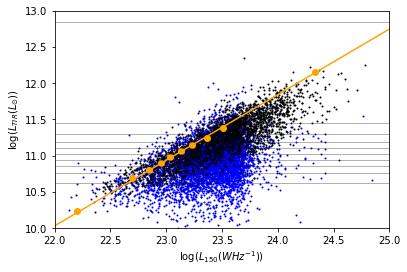

In [56]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]


'''mask_fir_det = return_fir_detected_mask(limit_data)
x = np.log10(limit_data['radio_luminosity_limit'][mask_fir_det][::3])
y = np.log10(limit_data['Ldust_bayes'][mask_fir_det][::3]/3.8E26)
plt.scatter(x,y,s=1,c='cyan')'''

#mask_det = det.astype(bool)
x = np.log10(limit_data['radio_luminosity_limit'][::3])
y = np.log10(limit_data['Ldust_bayes'][::3]/3.8E26)
plt.scatter(x,y,s=1,c='blue')


'''mask_fir_det = return_fir_detected_mask(detected_data)
x = np.log10(detected_data['radio_luminosity'][mask_fir_det][::3])
y = np.log10(detected_data['Ldust_bayes'][mask_fir_det][::3]/3.8E26)
plt.scatter(x,y,s=1,c='red')'''

x = np.log10(detected_data['radio_luminosity'][::3])
y = np.log10(detected_data['Ldust_bayes'][::3]/3.8E26)
plt.scatter(x,y,s=1,c='black')




ldusts = np.log10(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes']))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)





num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,xerr=xerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='orange')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')

hlines = np.array(bins_ldust) - np.log10(3.8E26)
plt.hlines(hlines,xmin=22,xmax=25,alpha=0.3,linewidth=1,color='black')

plt.xlim(22,25)
plt.ylim(10,13)
plt.xlabel('$\log( L_{150}(W Hz^{-1}) )$')
plt.ylabel('$\log( L_{TIR}(L_{\odot}) )$')
plt.savefig('plots/FIRC_nonlinearity.pdf',format='pdf')
plt.show()

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


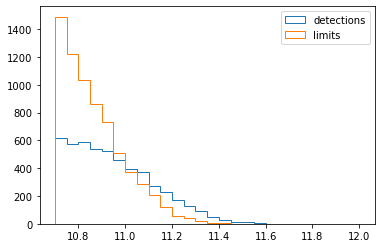

[0.07508182 0.4473     0.55238    0.6218     0.6796     0.7313
 0.7865     0.8347     0.8893     0.94793    0.9999    ]
power law fit parameters: alpha = -0.051695 +\- 0.0099696, N = 1.9551 +\- 0.0093563


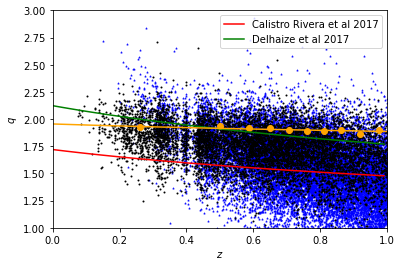

In [58]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'



mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

bins = np.arange(10.7,12,0.05)
y = np.log10(detected_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='detections')
y = np.log10(limit_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()

mask_det = det.astype(bool)
x = limit_data['Z_BEST']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')


redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(power_law,x,y,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')

plt.xlim(0,1)
plt.ylim(1,3)
plt.xlabel('$z$')
plt.ylabel('$q$')
plt.legend()
plt.savefig('plots/FIRC_z_evo.pdf',format='pdf')
plt.show()

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


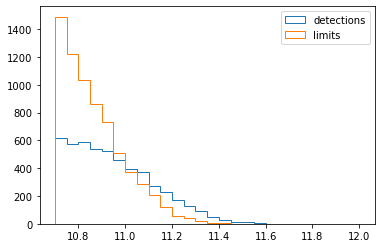

[0.07508182 0.4473     0.55238    0.6218     0.6796     0.7313
 0.7865     0.8347     0.8893     0.94793    0.9999    ]
power law fit parameters: m = -0.066198 +\- 0.013822, N = 1.9492 +\- 0.0081021


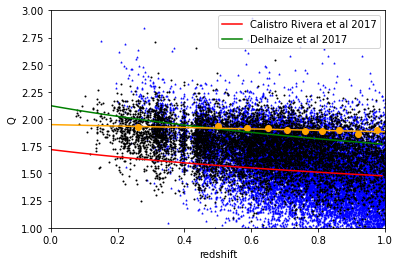

In [60]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

bins = np.arange(10.7,12,0.05)
y = np.log10(detected_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='detections')
y = np.log10(limit_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()

mask_det = det.astype(bool)
x = limit_data['Z_BEST']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')


redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(linear_fit,x,y,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: m = {m_mean:2.5} +\- {m_std:2.5}, N = {c_mean:2.5} +\- {c_std:2.5}')

plt.xlim(0,1)
plt.ylim(1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


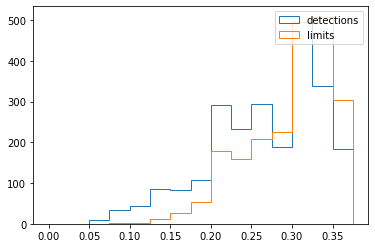

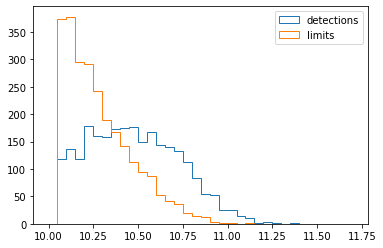

[10.04906876 10.10162295 10.15076618 10.21079898 10.26606192 10.33428926
 10.40752616 10.49327508 10.59167135 10.72948352 11.36323973]
power law fit parameters: alpha = 2.0593 +\- 0.0079931, N = -0.23157 +\- 0.01737
There are 2609 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[10.04906876 10.10245894 10.15235846 10.21194185 10.26793364 10.3379969
 10.4112653  10.49811284 10.5999654  10.73359826 11.36323973]
power law fit parameters: alpha = 2.0557 +\- 0.0076523, N = -0.23626 +\- 0.016262


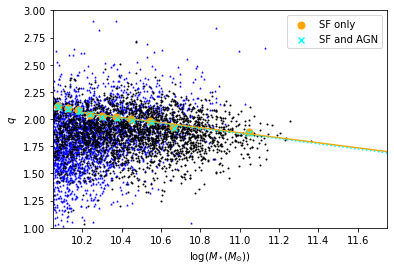

In [262]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

bins = np.arange(0,0.4,0.025)
y = detected_data['Z_BEST']
plt.hist(y,bins=bins,histtype='step',label='detections')
y = limit_data['Z_BEST']
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()

bins = np.arange(10,11.75,0.05)
y = np.log10(detected_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='detections')
y = np.log10(limit_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()


x = np.log10(limit_data['Mstar_bayes']/3.8E26)
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = np.log10(detected_data['Mstar_bayes']/3.8E26)
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')




redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',label='SF only',s=50)
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(linear_fit,x,y,po,sigma=yerr)
x = np.arange(0,2,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = linear_fit(x,N_mean,alpha_mean)
plt.plot(x+10.2,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
 
#repeat the process but without removing AGN

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for m,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if m==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
    
    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='cyan',marker='x',label='SF and AGN')
plt.errorbar(x,y,yerr=yerr,c='cyan',linestyle='')

#popt,pcov = curve_fit(linear_fit,x,y,po,sigma=yerr)
x = np.arange(0,2,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = linear_fit(x,N_mean,alpha_mean)
plt.plot(x+10.2,y,c='cyan',linestyle='dotted')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
 


plt.xlim(10.05,11.75)
plt.ylim(1,3)
plt.xlabel('$\log( M_*(M_{\odot}) )$')
plt.ylabel('$q$')
plt.legend()
plt.savefig('plots/FIRC_mstar_evo_agn.pdf',format='pdf')
plt.show()

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


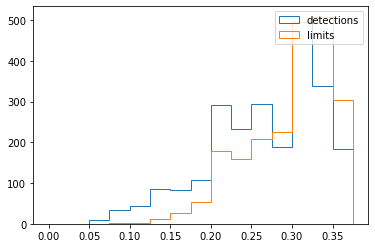

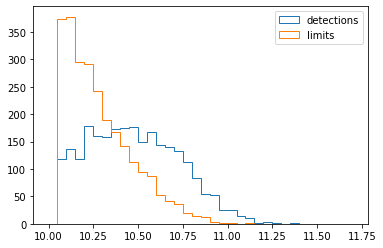

[10.04906876 10.10162295 10.15076618 10.21079898 10.26606192 10.33428926
 10.40752616 10.49327508 10.59167135 10.72948352 11.36323973]
power law fit parameters: m = -0.23123 +\- 0.016408, N = 2.0578 +\- 0.0076948


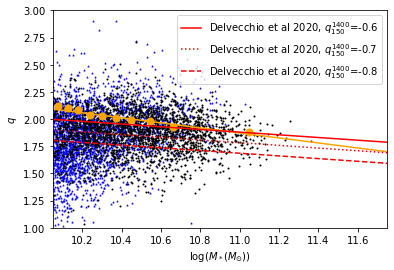

In [62]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

bins = np.arange(0,0.4,0.025)
y = detected_data['Z_BEST']
plt.hist(y,bins=bins,histtype='step',label='detections')
y = limit_data['Z_BEST']
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()

bins = np.arange(10,11.75,0.05)
y = np.log10(detected_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='detections')
y = np.log10(limit_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()


x = np.log10(limit_data['Mstar_bayes']/3.8E26)
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = np.log10(detected_data['Mstar_bayes']/3.8E26)
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')




redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',s=50)
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x+10.2,y,c='orange')

print(f'power law fit parameters: m = {m_mean:2.5} +\- {m_std:2.5}, N = {c_mean:2.5} +\- {c_std:2.5}')
 


x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.6))
plt.plot(x,y,c='red',linestyle='solid',label='Delvecchio et al 2020, $q^{1400}_{150}$=-0.6')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.7))
plt.plot(x,y,c='red',linestyle='dotted',label='Delvecchio et al 2020, $q^{1400}_{150}$=-0.7')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.8))
plt.plot(x,y,c='red',linestyle='dashed',label='Delvecchio et al 2020, $q^{1400}_{150}$=-0.8')

#plt.scatter()


plt.xlim(10.05,11.75)
plt.ylim(1,3)
plt.xlabel('$\log( M_*(M_{\odot}) )$ ')
plt.ylabel('$q$')
plt.legend()
plt.savefig('plots/FIRC_mstar_evo_linear.pdf',format='pdf')
plt.show()

There are 8020 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 41763 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


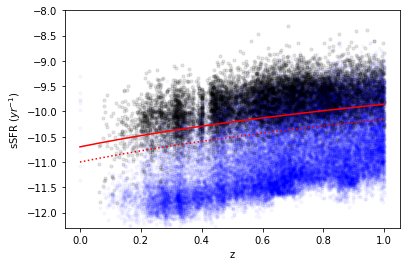

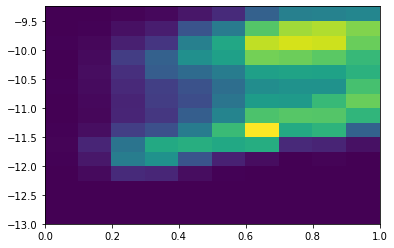

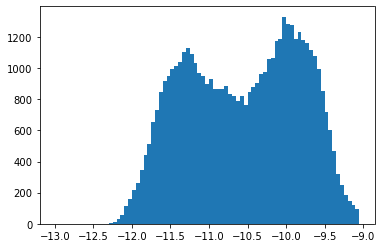

In [36]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7


mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

x2 = np.log10(limit_sample_en1['SFR_bayes']) - np.log10(limit_sample_en1['Mstar_bayes']/3.8E26)
y2 = limit_sample_en1['Z_BEST']
plt.scatter(y2,x2,s=10,alpha=0.03,c='blue')
plt.xlabel("z")
plt.ylabel('sSFR ($yr^{-1}$)')

x1 = np.log10(detected_sample_en1['SFR_bayes']) - np.log10(detected_sample_en1['Mstar_bayes']/3.8E26)# - np.log10(3.8*10**26)
y1 = detected_sample_en1['Z_BEST']
plt.scatter(y1,x1,s=10,alpha=0.1,c='black')



x = np.arange(0,1,0.0001)
y = np.log10(power_law(x,1,2.8)) - np.log10(5E10)
plt.plot(x,y,c='red')

x = np.arange(0,1,0.0001)
y = np.log10(power_law(x,1,2.8)) - np.log10(5E10) - 0.3
plt.plot(x,y,c='red',linestyle='dotted')

plt.ylim(-12.3,-8)
plt.savefig('plots/sSFR_cut.pdf',format='pdf')
plt.show()


x = np.append(y1,y2)
y = np.append(x1,x2)
z_bin = np.arange(0,1.1,0.1)
ssfr_bin = np.arange(-13,-9,0.25)
bins = np.meshgrid(z_bin,ssfr_bin)
plt.hist2d(x,y,bins=[z_bin,ssfr_bin])
plt.show()

plt.hist(y,bins=np.arange(-13,-9,0.05))
plt.show()

There are 8020 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 41763 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


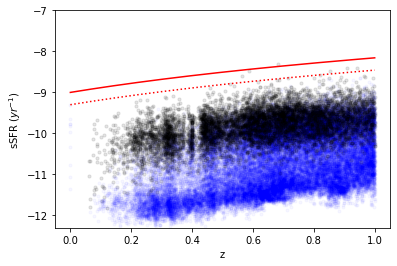

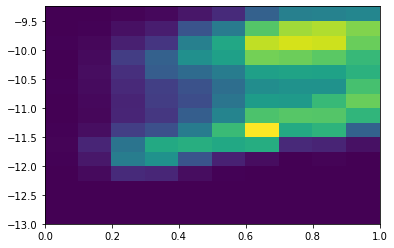

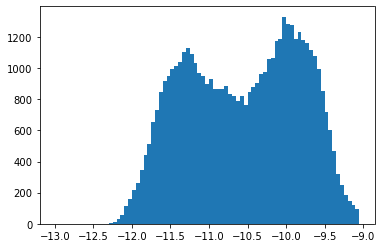

In [41]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7


mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

x2 = np.log10(limit_sample_en1['SFR_bayes']) - np.log10(limit_sample_en1['Mstar_bayes']/3.8E26) #+ (limit_sample_en1['Mstar_bayes']/3.8E26/5E10)
y2 = limit_sample_en1['Z_BEST']
plt.scatter(y2,x2,s=10,alpha=0.03,c='blue')
plt.xlabel("z")
plt.ylabel('sSFR ($yr^{-1}$)')

x1 = np.log10(detected_sample_en1['SFR_bayes']) - np.log10(detected_sample_en1['Mstar_bayes']/3.8E26) #+ (detected_sample_en1['Mstar_bayes']/3.8E26/5E10)# - np.log10(3.8*10**26)
y1 = detected_sample_en1['Z_BEST']
plt.scatter(y1,x1,s=10,alpha=0.1,c='black')



x = np.arange(0,1,0.0001)
y = np.log10(power_law(x,1,2.8)) - np.log10(1E9)
plt.plot(x,y,c='red')

x = np.arange(0,1,0.0001)
y = np.log10(power_law(x,1,2.8)) - np.log10(1E9) - 0.3
plt.plot(x,y,c='red',linestyle='dotted')

plt.ylim(-12.3,-7)
plt.savefig('plots/sSFR_cut.pdf',format='pdf')
plt.show()


x = np.append(y1,y2)
y = np.append(x1,x2)
z_bin = np.arange(0,1.1,0.1)
ssfr_bin = np.arange(-13,-9,0.25)
bins = np.meshgrid(z_bin,ssfr_bin)
plt.hist2d(x,y,bins=[z_bin,ssfr_bin])
plt.show()

plt.hist(y,bins=np.arange(-13,-9,0.05))
plt.show()

In [39]:
(detected_sample_en1['Mstar_bayes']/3.8E26/5E10)

1.9265300587789473
1.3465855245473686
2.837988017852631
1.571249917305263
2.417539395368421
0.6856713485473684
1.6616247511578945
3.7570567760842106
2.2475221099789473
0.5922916890947368
1.2085944751157895


ValueError: neither 'samples' nor 'bootnum' can be less than 1.

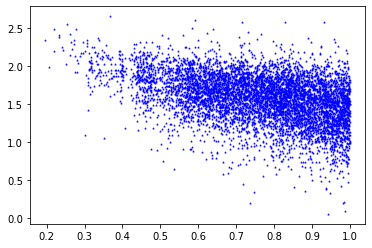

In [64]:
#See if the choice of SSFR cut affects the results

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'



ssfr_lims = np.arange(-10.7,-10.2,0.1)
for ssfr_lim in ssfr_lims: 
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)# & mask_loc
    agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
    SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26)) > ssfr_lim
    detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]



    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)# & mask_loc
    SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median']) > ssfr_lim
    limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]


    mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
    detected_data = detected_data[mask]

    mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
    limit_data = limit_data[mask]


    mask_det = det.astype(bool)
    x = limit_data['Z_BEST']
    y = limit_data[lim_name]
    plt.scatter(x,y,s=1,marker='^',c='blue')

    x = detected_data['Z_BEST']
    y = detected_data[det_name]
    plt.scatter(x,y,s=1,c='black',)




    redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
    bins_z = []
    percentiles = np.linspace(0,100,11)
    for n,percent in enumerate(percentiles):
        bins_z.append(np.percentile(redshifts,percent))
    bins_z = np.array(bins_z)


    num = 100
    N = int(len(detected_data)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
    N = int(len(limit_data)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

    median_q = []
    kmfs = []
    popts = []
    pcovs = []
    for n in range(num):
        data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
        ldust_det = detected_data[ldust_name][bootstrap_det[n]]

        redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
        ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        kmfs.append(kmf)


        redshifts = np.append(redshift_det,redshift_lim)



        test = np.digitize(redshifts,bins=bins_z)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        median_q_err = []
        for n,num in enumerate(nums_z[:len(bins_z)-1]):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]

            redshift_binned.append(redshifts[mask])



            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

            if n==20:
                bins = np.arange(-3,4,0.1)
                fig,ax1 = plt.subplots()

                ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
                ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

                ax2 = ax1.twinx()
                x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
                y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
                ax2.plot(x,y)
                lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
                upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
                ax2.fill_between(x,lowx,upx,alpha=0.3)
                ax2.set_ylabel('CDF')

                plt.vlines(kmf.median_survival_time_,0,2000)
                plt.ylim(0,1.1)
                plt.xlim(-0.5,3)
                ax1.set_xlabel('q')
                ax1.set_ylabel('N')
                ax1.legend(loc='upper left')
                plt.show()

            x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            x = np.arange(-1,3,0.01)

            lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
            upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

            err = upx-lowx

            mean_q_agnfitter.append(kmf.median_)
            median_q_err.append(err)

        x = get_center(bins_z)
        y = mean_q_agnfitter   
        popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)

        median_q.append(mean_q_agnfitter)
        popts.append(popt)
        pcovs.append([pcov[0,0],pcov[1,1]])

    '''    x = get_center(bins_z)
        y = mean_q_agnfitter[:-1]
        plt.scatter(x,y,c='orange')
        yerr = median_q_err[:-1]
        plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

    median_q = np.array(median_q)
    popts = np.array(popts)
    pcovs = np.array(pcovs)
    medians = np.mean(median_q,axis=0)
    errs = np.std(median_q,axis=0)

    x = get_center(bins_z)
    y = medians
    yerr = errs
    #plt.scatter(x,y,c='orange')
    #plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

    #popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
    x = np.arange(0,1,0.001)
    N_mean = np.mean(popts[:,0])
    N_std = np.std(popts[:,0])
    alpha_mean = np.mean(popts[:,1])
    alpha_std = np.std(popts[:,1])
    y = power_law(x,N_mean,alpha_mean)
    plt.plot(x,y,label=ssfr_lim)

    print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')

    
x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')
    
plt.ylim(0.5,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters: m = -0.22988 +\- 0.01459, c = 2.0581 +\- 0.0076516


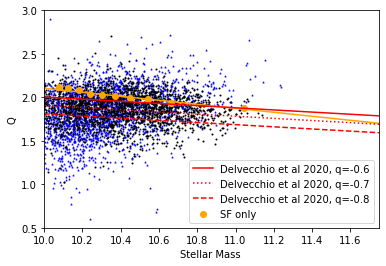

In [67]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]



mask_det = det.astype(bool)
x = limit_data['Mass_median']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Mass_median']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')




redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001



num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',label='SF only')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x+10.2,y,c='orange')
#y = linear_fit(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')

print(f'power law fit parameters: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')


x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.6))
plt.plot(x,y,c='red',linestyle='solid',label='Delvecchio et al 2020, q=-0.6')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.7))
plt.plot(x,y,c='red',linestyle='dotted',label='Delvecchio et al 2020, q=-0.7')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.8))
plt.plot(x,y,c='red',linestyle='dashed',label='Delvecchio et al 2020, q=-0.8')




plt.xlim(10.0,11.75)
plt.ylim(0.5,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend()
plt.show()

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters: m = -0.026654 +\- 0.016198, c = 1.9288 +\- 0.0073075


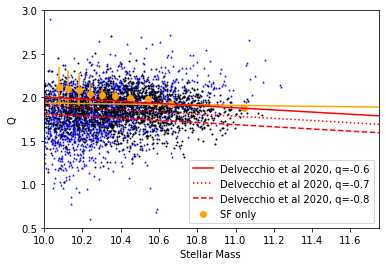

In [108]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]



mask_det = det.astype(bool)
x = limit_data['Mass_median']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Mass_median']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')




redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001



num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask] - yerr_kmf,sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2 + yerr_kmf**2)
plt.scatter(x,y,c='orange',label='SF only')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x+10.2,y,c='orange')
#y = linear_fit(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')

print(f'power law fit parameters: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')


x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.6))
plt.plot(x,y,c='red',linestyle='solid',label='Delvecchio et al 2020, q=-0.6')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.7))
plt.plot(x,y,c='red',linestyle='dotted',label='Delvecchio et al 2020, q=-0.7')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.8))
plt.plot(x,y,c='red',linestyle='dashed',label='Delvecchio et al 2020, q=-0.8')




plt.xlim(10.0,11.75)
plt.ylim(0.5,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend()
plt.show()

In [183]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]





redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001


#calculate the correction that will be applied
correction_params = np.array([])
for n in range(len(bins_z)-1):
    flims = np.arange(75,801,25)*1E-6
    spectral_index = -0.63
    
    mask = (np.log10(detected_data['Mstar_bayes']/3.8E26)>bins_z[n]) & (np.log10(detected_data['Mstar_bayes']/3.8E26)<bins_z[n+1])
    data = detected_data[mask].copy()
    mask = (np.log10(limit_data['Mstar_bayes']/3.8E26)>bins_z[n]) & (np.log10(limit_data['Mstar_bayes']/3.8E26)<bins_z[n+1])
    lim_data = limit_data[mask].copy()
    
    dist = cosmo.luminosity_distance(data['Z_BEST']).to(u.m).value

    medians = []
    errs = []
    ratio = []
    for m,flim in enumerate(flims):
        mask_det = data['Total_flux']>flim
        q_det = data[det_name][mask_det]


        z = data['Z_BEST'][~mask_det]
        #lrad_lims = flim*(4*np.pi*dist[~mask_det]**2 * (1+z)**(-1-spectral_index)) * 1E26
        lrad_lims = flim*4*np.pi*dist[~mask_det]**2 * 1E-26 * (1+z)**(-1-spectral_index)

        new_q_lims = np.log10(data['Ldust_bayes'][~mask_det]/3.75E12) - np.log10(lrad_lims)
        q_lim = np.append(new_q_lims,lim_data[lim_name])

        ratio.append(len(q_det)/len(q_lim))


        num = 100
        N = int(len(q_det)*0.9)
        bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
        N = int(len(q_lim)*0.9)
        bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

        median_q = []
        for n in range(num):
            qs = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
            #data[flag_detected] = q_lim[flag_detected]
            qs_det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))


            kmf = KaplanMeierFitter() 

            ## Fit the data into the model
            kmf.fit(qs, qs_det,label='Kaplan Meier Estimate')

            median_q.append(kmf.median_survival_time_)



        median_q = np.array(median_q)

        medians.append(np.mean(median_q))
        errs.append(np.std(median_q))
    
    if np.max(ratio)>1.5:
        mask = np.array(ratio)<3.5
        x = np.array(ratio)[mask]
        y = np.array(medians)[mask]
        yerr = np.array(errs)[mask]
        mask = (~np.isnan(y)) & (~np.isinf(y))
        x = x[mask]
        y = y[mask]
        yerr = yerr[mask]

        popt,pcov = curve_fit(fit_func,x,y,sigma=yerr)
        correction_params = np.append(correction_params,popt)

correction = np.array([])
correction_params = correction_params.reshape(int(len(correction_params)/3),3)
for n in range(len(correction_params)):
    correction = np.append(correction,fit_func(0.5,correction_params[n,0],correction_params[n,1],correction_params[n,2]))
correction_fit_mass = correction_params[np.argmax(correction)]

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters without correction: m = -0.2284 +\- 0.01012, c = 2.0568 +\- 0.0046146
power law fit parameters with correction: m = -0.1057 +\- 0.010952, c = 1.9821 +\- 0.007614


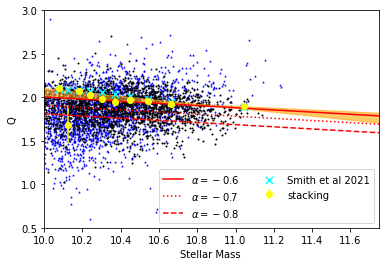

In [259]:
#calculate the mass evolution when applying corrections to the incomplete bins

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

mask_det = det.astype(bool)
x = limit_data['Mass_median']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Mass_median']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')


x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.6))
plt.plot(x,y,c='red',linestyle='solid',label=r'$\alpha = -0.6$')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.7))
plt.plot(x,y,c='red',linestyle='dotted',label=r'$\alpha = -0.7$')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.8))
plt.plot(x,y,c='red',linestyle='dashed',label=r'$\alpha = -0.8$')


redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
#plt.scatter(x,y,c='orange',label='SF only')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y_uncorr = linear_fit(x,m_mean,c_mean)
#plt.plot(x+10.2,y_uncorr,c='orange')
#y = linear_fit(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')

print(f'power law fit parameters without correction: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')




    
num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr_kmf = abs(fit_func(ratios,correction_fit_mass[0],correction_fit_mass[1],0) - fit_func(5,correction_fit_mass[0],correction_fit_mass[1],0))
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask] - yerr_kmf,sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
#plt.scatter(x,y,c='orange',label='SF only')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean_corr = np.mean(popts[:,0])
m_std_corr = np.std(popts[:,0])
c_mean_corr = np.mean(popts[:,1])
c_std_corr = np.std(popts[:,1])
y_corr = linear_fit(x,m_mean_corr,c_mean_corr)
#plt.plot(x+10.2,y_corr,c='orange')
#y = linear_fit(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')


plt.fill_between(x+10.2,y_uncorr,y_corr,color='orange',alpha=0.6)

print(f'power law fit parameters with correction: m = {m_mean_corr:2.5} +\- {m_std_corr:2.5}, c = {c_mean_corr:2.5} +\- {c_std_corr:2.5}')



x = get_center(bins_z)
y = qs_smith
plt.scatter(x,y,s=50,c='cyan',marker='x',label='Smith et al 2021')

x = get_center(bins_z)
y = qs_stacking
yerr = qs_stacking_err
plt.errorbar(x,y,yerr=yerr,c='yellow',marker='o',label='stacking',linestyle='')



plt.xlim(10.0,11.75)
plt.ylim(0.5,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend(ncol=2)
plt.savefig('plots/FIRC_mstar_evo_corr.pdf',format='pdf')
plt.show()

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters without correction: m = 2.0658 +\- 0.010287, c = -0.15667 +\- 0.010368
power law fit parameters with correction: m = 1.9865 +\- 0.0070666, c = -0.074391 +\- 0.011143


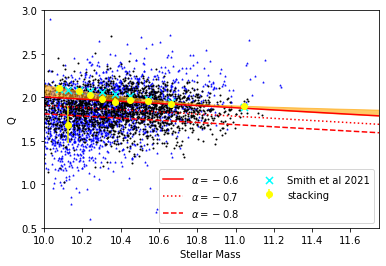

In [254]:
#calculate the mass evolution when applying corrections to the incomplete bins

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

mask_det = det.astype(bool)
x = limit_data['Mass_median']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Mass_median']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')


x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.6))
plt.plot(x,y,c='red',linestyle='solid',label=r'$\alpha = -0.6$')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.7))
plt.plot(x,y,c='red',linestyle='dotted',label=r'$\alpha = -0.7$')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.8))
plt.plot(x,y,c='red',linestyle='dashed',label=r'$\alpha = -0.8$')


redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(power_law,x[mask]-10.2,y[mask],sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
#plt.scatter(x,y,c='orange',label='SF only')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y_uncorr = power_law(x,m_mean,c_mean)
#plt.plot(x+10.2,y_uncorr,c='orange')
#y = power_law(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')

print(f'power law fit parameters without correction: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')




    
num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr_kmf = abs(fit_func(ratios,correction_fit_mass[0],correction_fit_mass[1],0) - fit_func(5,correction_fit_mass[0],correction_fit_mass[1],0))
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(power_law,x[mask]-10.2,y[mask] - yerr_kmf,sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
#plt.scatter(x,y,c='orange',label='SF only')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean_corr = np.mean(popts[:,0])
m_std_corr = np.std(popts[:,0])
c_mean_corr = np.mean(popts[:,1])
c_std_corr = np.std(popts[:,1])
y_corr = power_law(x,m_mean_corr,c_mean_corr)
#plt.plot(x+10.2,y_corr,c='orange')
#y = power_law(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')


plt.fill_between(x+10.2,y_uncorr,y_corr,color='orange',alpha=0.6)

print(f'power law fit parameters with correction: m = {m_mean_corr:2.5} +\- {m_std_corr:2.5}, c = {c_mean_corr:2.5} +\- {c_std_corr:2.5}')



x = get_center(bins_z)
y = qs_smith
plt.scatter(x,y,s=50,c='cyan',marker='x',label='Smith et al 2021')

x = get_center(bins_z)
y = qs_stacking
yerr = qs_stacking_err
plt.errorbar(x,y,yerr=yerr,c='yellow',marker='o',label='stacking',linestyle='')



plt.xlim(10.0,11.75)
plt.ylim(0.5,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend(ncol=2)
plt.show()

In [223]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]





redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


#calculate the correction that will be applied
correction_params = np.array([])
for n in range(len(bins_z)-1):
    flims = np.arange(75,801,25)*1E-6
    spectral_index = -0.63
    
    mask = (detected_data['Z_BEST']>bins_z[n]) & (detected_data['Z_BEST']<bins_z[n+1])
    data = detected_data[mask].copy()
    mask = (limit_data['Z_BEST']>bins_z[n]) & (limit_data['Z_BEST']<bins_z[n+1])
    lim_data = limit_data[mask].copy()
    
    dist = cosmo.luminosity_distance(data['Z_BEST']).to(u.m).value

    medians = []
    errs = []
    ratio = []
    for m,flim in enumerate(flims):
        mask_det = data['Total_flux']>flim
        q_det = data[det_name][mask_det]


        z = data['Z_BEST'][~mask_det]
        #lrad_lims = flim*(4*np.pi*dist[~mask_det]**2 * (1+z)**(-1-spectral_index)) * 1E26
        lrad_lims = flim*4*np.pi*dist[~mask_det]**2 * 1E-26 * (1+z)**(-1-spectral_index)

        new_q_lims = np.log10(data['Ldust_bayes'][~mask_det]/3.75E12) - np.log10(lrad_lims)
        q_lim = np.append(new_q_lims,lim_data[lim_name])

        ratio.append(len(q_det)/len(q_lim))


        num = 100
        N = int(len(q_det)*0.9)
        bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
        N = int(len(q_lim)*0.9)
        bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

        median_q = []
        for n in range(num):
            qs = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
            #data[flag_detected] = q_lim[flag_detected]
            qs_det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))


            kmf = KaplanMeierFitter() 

            ## Fit the data into the model
            kmf.fit(qs, qs_det,label='Kaplan Meier Estimate')

            median_q.append(kmf.median_survival_time_)



        median_q = np.array(median_q)

        medians.append(np.mean(median_q))
        errs.append(np.std(median_q))
    
    if np.max(ratio)>1.5:
        mask = np.array(ratio)<3.5
        x = np.array(ratio)[mask]
        y = np.array(medians)[mask]
        yerr = np.array(errs)[mask]
        mask = (~np.isnan(y)) & (~np.isinf(y))
        x = x[mask]
        y = y[mask]
        yerr = yerr[mask]

        popt,pcov = curve_fit(fit_func,x,y,sigma=yerr)
        correction_params = np.append(correction_params,popt)

correction = np.array([])
correction_params = correction_params.reshape(int(len(correction_params)/3),3)
for n in range(len(correction_params)):
    correction = np.append(correction,fit_func(0.5,correction_params[n,0],correction_params[n,1],correction_params[n,2]))
correction_fit_redshift = correction_params[np.argmax(correction)]

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[0.07508182 0.4473     0.55238    0.6218     0.6796     0.7313
 0.7865     0.8347     0.8893     0.94793    0.9999    ]


In [224]:
correction_params

array([[ 1.54999172, 38.48604788,  1.91461595]])

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[0.07508182 0.4473     0.55238    0.6218     0.6796     0.7313
 0.7865     0.8347     0.8893     0.94793    0.9999    ]
power law fit parameters uncorrected: m = -0.068379 +\- 0.016981, N = 1.9505 +\- 0.0089835
power law fit parameters corrected: m = -0.41874 +\- 0.01223, N = 2.063 +\- 0.0067348


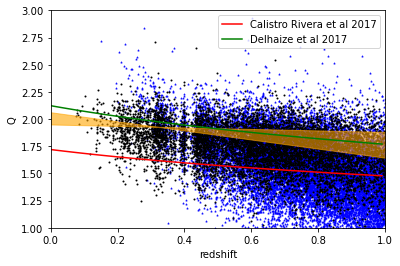

In [231]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]



mask_det = det.astype(bool)
x = limit_data['Z_BEST']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')


redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(linear_fit,x,y,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
#plt.scatter(x,y,c='orange')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y_uncorr = linear_fit(x,m_mean,c_mean)
#plt.plot(x,y,c='orange')

print(f'power law fit parameters uncorrected: m = {m_mean:2.5} +\- {m_std:2.5}, N = {c_mean:2.5} +\- {c_std:2.5}')



num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter
    corr = abs(fit_func(ratios,correction_fit_redshift[0],correction_fit_redshift[1],0) - fit_func(5,correction_fit_redshift[0],correction_fit_redshift[1],0))
    popt,pcov = curve_fit(linear_fit,x,y-corr,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
#plt.scatter(x,y,c='orange')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y_corr = linear_fit(x,m_mean,c_mean)
#plt.plot(x,y,c='orange')

print(f'power law fit parameters corrected: m = {m_mean:2.5} +\- {m_std:2.5}, N = {c_mean:2.5} +\- {c_std:2.5}')


plt.fill_between(x,y_uncorr,y_corr,color='orange',alpha=0.6)


plt.xlim(0,1)
plt.ylim(1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[0.07508182 0.4473     0.55238    0.6218     0.6796     0.7313
 0.7865     0.8347     0.8893     0.94793    0.9999    ]
power law fit parameters uncorrected: m = 1.954 +\- 0.0054591, N = -0.048966 +\- 0.0060978
power law fit parameters corrected: N = 2.1189 +\- 0.011916, alpha = -0.34683 +\- 0.012189


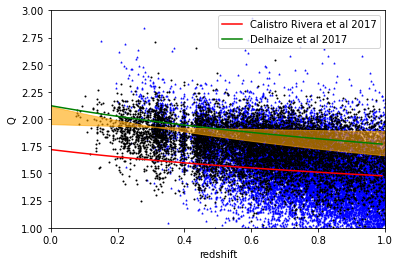

In [260]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]



mask_det = det.astype(bool)
x = limit_data['Z_BEST']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')


redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(power_law,x,y,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
#plt.scatter(x,y,c='orange')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y_uncorr = power_law(x,m_mean,c_mean)
#plt.plot(x,y,c='orange')

print(f'power law fit parameters uncorrected: m = {m_mean:2.5} +\- {m_std:2.5}, N = {c_mean:2.5} +\- {c_std:2.5}')



num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter
    corr = abs(fit_func(ratios,correction_fit_redshift[0],correction_fit_redshift[1],0) - fit_func(5,correction_fit_redshift[0],correction_fit_redshift[1],0))
    popt,pcov = curve_fit(power_law,x,y-corr,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
#plt.scatter(x,y,c='orange')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y_corr = power_law(x,m_mean,c_mean)
#plt.plot(x,y,c='orange')

print(f'power law fit parameters corrected: N = {m_mean:2.5} +\- {m_std:2.5}, alpha = {c_mean:2.5} +\- {c_std:2.5}')


plt.fill_between(x,y_uncorr,y_corr,color='orange',alpha=0.6)


plt.xlim(0,1)
plt.ylim(1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.savefig('plots/FIRC_z_evo_corr.pdf',format='pdf')
plt.show()

In [246]:
mean_q_agnfitter-corr

array([1.9228762 , 1.88757422, 1.84215304, 1.83140485, 1.78247569,
       1.75310093, 1.70969488, 1.72389119, 1.64199699, 1.52100522])

In [235]:
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]





ldusts = np.log10(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes']))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)


#calculate the correction that will be applied
correction_params = np.array([])
for n in range(len(bins_ldust)-1):
    flims = np.arange(75,801,25)*1E-6
    spectral_index = -0.63
    
    mask = (np.log10(detected_data['Ldust_bayes'])>bins_ldust[n]) & (np.log10(detected_data['Ldust_bayes'])<bins_ldust[n+1])
    data = detected_data[mask].copy()
    mask = (np.log10(limit_data['Ldust_bayes'])>bins_ldust[n]) & (np.log10(limit_data['Ldust_bayes'])<bins_ldust[n+1])
    lim_data = limit_data[mask].copy()
    
    dist = cosmo.luminosity_distance(data['Z_BEST']).to(u.m).value

    medians = []
    errs = []
    ratio = []
    for m,flim in enumerate(flims):
        mask_det = data['Total_flux']>flim
        q_det = data[det_name][mask_det]


        z = data['Z_BEST'][~mask_det]
        #lrad_lims = flim*(4*np.pi*dist[~mask_det]**2 * (1+z)**(-1-spectral_index)) * 1E26
        lrad_lims = flim*4*np.pi*dist[~mask_det]**2 * 1E-26 * (1+z)**(-1-spectral_index)

        new_q_lims = np.log10(data['Ldust_bayes'][~mask_det]/3.75E12) - np.log10(lrad_lims)
        q_lim = np.append(new_q_lims,lim_data[lim_name])

        ratio.append(len(q_det)/len(q_lim))


        num = 100
        N = int(len(q_det)*0.9)
        bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
        N = int(len(q_lim)*0.9)
        bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

        median_q = []
        for n in range(num):
            qs = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
            #data[flag_detected] = q_lim[flag_detected]
            qs_det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))


            kmf = KaplanMeierFitter() 

            ## Fit the data into the model
            kmf.fit(qs, qs_det,label='Kaplan Meier Estimate')

            median_q.append(kmf.median_survival_time_)



        median_q = np.array(median_q)

        medians.append(np.mean(median_q))
        errs.append(np.std(median_q))
    
    if np.max(ratio)>1.5:
        mask = np.array(ratio)<3.5
        x = np.array(ratio)[mask]
        y = np.array(medians)[mask]
        yerr = np.array(errs)[mask]
        mask = (~np.isnan(y)) & (~np.isinf(y))
        x = x[mask]
        y = y[mask]
        yerr = yerr[mask]

        popt,pcov = curve_fit(fit_func,x,y,sigma=yerr)
        correction_params = np.append(correction_params,popt)

correction = np.array([])
correction_params = correction_params.reshape(int(len(correction_params)/3),3)
for n in range(len(correction_params)):
    correction = np.append(correction,fit_func(0.5,correction_params[n,0],correction_params[n,1],correction_params[n,2]))
correction_fit_ldust = correction_params[np.argmax(correction)]

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


In [236]:
correction_fit_ldust

array([ 1.71243065, 32.96219336,  1.82306465])

There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
linear fit parameters: m = 0.90536 +\- 0.0050482, c = -9.8885 +\- 0.19296
linear fit parameters: m = 0.64573 +\- 0.01583, c = -3.6747 +\- 0.60471


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power


linear fit parameters: m = 0.83185 +\- 0.014839, c = -8.1684 +\- 0.56095
linear fit parameters: m = 0.81516 +\- 0.026454, c = -7.7846 +\- 1.0012


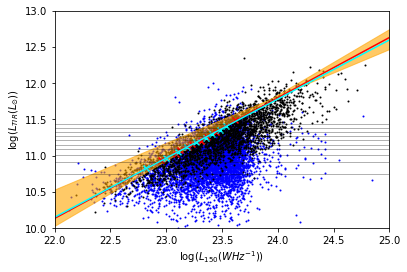

In [258]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]


'''mask_fir_det = return_fir_detected_mask(limit_data)
x = np.log10(limit_data['radio_luminosity_limit'][mask_fir_det][::3])
y = np.log10(limit_data['Ldust_bayes'][mask_fir_det][::3]/3.8E26)
plt.scatter(x,y,s=1,c='cyan')'''

#mask_det = det.astype(bool)
x = np.log10(limit_data['radio_luminosity_limit'][::3])
y = np.log10(limit_data['Ldust_bayes'][::3]/3.8E26)
plt.scatter(x,y,s=1,c='blue')


'''mask_fir_det = return_fir_detected_mask(detected_data)
x = np.log10(detected_data['radio_luminosity'][mask_fir_det][::3])
y = np.log10(detected_data['Ldust_bayes'][mask_fir_det][::3]/3.8E26)
plt.scatter(x,y,s=1,c='red')'''

x = np.log10(detected_data['radio_luminosity'][::3])
y = np.log10(detected_data['Ldust_bayes'][::3]/3.8E26)
plt.scatter(x,y,s=1,c='black')




ldusts = np.log10(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes']))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)





num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
#plt.scatter(x,y,c='orange')
#plt.errorbar(x,y,xerr=xerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y_uncorr = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
#plt.plot(x,y,c='orange')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    corr = abs(fit_func(ratios[mask],correction_fit_ldust[0],correction_fit_ldust[1],0) - fit_func(5,correction_fit_ldust[0],correction_fit_ldust[1],0))
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask] - corr,sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
#plt.scatter(x,y,c='orange')
#plt.errorbar(x,y,xerr=xerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y_corr = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
#plt.plot(x,y,c='orange')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')

plt.fill_between(x,y_uncorr,y_corr,color='orange',alpha=0.6)



pred_SFR = main_sequnce_calc_schreiber2015(detected_data['Mstar_bayes']/3.8E26,detected_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_schreiber',data=pred_TIR)
detected_data.add_column(col_pred_TIR)


pred_SFR = main_sequnce_calc_schreiber2015(limit_data['Mstar_bayes']/3.8E26,limit_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_schreiber',data=pred_TIR)
limit_data.add_column(col_pred_TIR)

pred_SFR = main_sequence_calc_leslie2020(detected_data['Mstar_bayes']/3.8E26,detected_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_leslie',data=pred_TIR)
detected_data.add_column(col_pred_TIR)


pred_SFR = main_sequence_calc_leslie2020(limit_data['Mstar_bayes']/3.8E26,limit_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_leslie',data=pred_TIR)
limit_data.add_column(col_pred_TIR)

ldusts = np.log10(np.append(detected_data['pred_TIR_schreiber']*3.8E26,limit_data['pred_TIR_schreiber']*3.8E26))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)



num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
plt.scatter(x,y,c='red',marker='x')
plt.errorbar(x,y,xerr=xerr,c='red',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='red')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')



ldusts = np.log10(np.append(detected_data['pred_TIR_leslie']*3.8E26,limit_data['pred_TIR_leslie']*3.8E26))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)



num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
plt.scatter(x,y,c='cyan',marker='x')
plt.errorbar(x,y,xerr=xerr,c='cyan',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='cyan')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')




hlines = np.array(bins_ldust) - np.log10(3.8E26)
plt.hlines(hlines,xmin=22,xmax=25,alpha=0.3,linewidth=1,color='black')

plt.xlim(22,25)
plt.ylim(10,13)
plt.xlabel('$\log( L_{150}(W Hz^{-1}) )$')
plt.ylabel('$\log( L_{TIR}(L_{\odot}) )$')
plt.savefig('plots/FIRC_nonlinearity.pdf',format='pdf')
plt.show()

## Compare with Calistro Rivera et al 2017

In [69]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)

mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<3.5) & (lofar_sed_en1['Peak_flux']>0.0006) & (~agn_mask)
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
detected_sample_en1_calistro = lofar_sed_en1[mask_mass_complete_en1]


There are 1066 galaxies detected in the radio with a stellar mass>10.7 and z<1


There are 1069 galaxies detected in the radio with a stellar mass>10.7 and z<1
[0.0094     0.1182648  0.20357416 0.2539     0.3187     0.458
 0.63672    0.88318504 1.23724    1.9588     3.9357    ]
power law fit parameters: alpha = -0.27951 +\- 0.018387, N = 1.8513 +\- 0.013239


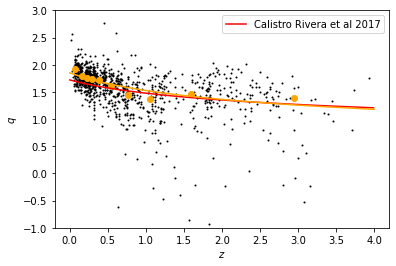

In [70]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_agnfitter'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)

mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<4.0)  & (lofar_sed_en1['Peak_flux']>0.0006) & (~agn_mask)
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
detected_sample_en1_calistro = lofar_sed_en1[mask_mass_complete_en1]




detected_data = detected_sample_en1_calistro.copy()
mask = (~np.isnan(detected_sample_en1_calistro[det_name])) & (~np.isinf(detected_sample_en1_calistro[det_name]))
detected_data = detected_sample_en1_calistro[mask]






x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)

x = np.arange(0,4,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')


redshifts = detected_data['Z_BEST']
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)


median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = detected_data[bootstrap_det[n]][det_name].astype('float64')
    #data[flag_detected] = q_lim[flag_detected]
    det = np.ones(len(bootstrap_det[n]))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = redshift_det
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]


        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(power_law,x,y,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,4,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
    
plt.ylim(-1,3)
plt.xlabel('$z$')
plt.ylabel('$q$')
plt.legend()
plt.savefig('plots/FIRC_z_evo_calistro_selection.pdf',format='pdf')
plt.show()

In [ ]:
data.dtype = 'float64'
data.dtype

## Comapre with Wang et al 2019

In [ ]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = np.log10(lofar_sed_en1['Ldust_bayes']/3.8e26)>10.5
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask]
mask = (~np.isinf(detected_data[det_name])) & (~np.isnan(detected_data[det_name]))
detected_data = detected_data[mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))



mask_mass_complete_limit_en1 = np.log10(lofar_magphys_en1['Ldust_bayes']/3.8e26)>10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1]
mask = (~np.isinf(limit_data[lim_name])) & (~np.isnan(limit_data[lim_name]))
limit_data = limit_data[mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))




#mask_det = det.astype(bool)
x = np.log10(limit_data['radio_luminosity_limit'])
y = np.log10(limit_data['Ldust_bayes']/3.8E26)
plt.scatter(x,y,s=1,marker='^',c='blue')

x = np.log10(detected_data['radio_luminosity'])
y = np.log10(detected_data['Ldust_bayes']/3.8E26)
plt.scatter(x,y,s=1,c='black')




ldusts = np.log10(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes']))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)
print(bins_ldust)


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,xerr=xerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='orange')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')

hlines = np.array(bins_ldust) - np.log10(3.8E26)
plt.hlines(hlines,xmin=22,xmax=25,alpha=0.3,linewidth=1,color='black')

plt.xlim(22,25)
plt.ylim(10,13)
plt.xlabel('log(150MHz luminosity W)')
plt.ylabel('log(ldust ($L_*$) )')

plt.show()

## Check that difference in radio vs IR depths doesn't bias results

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


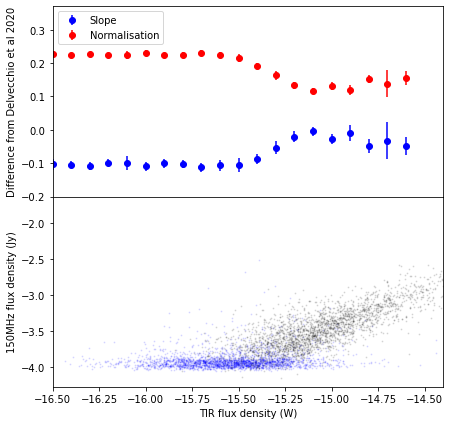

In [71]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

lir_bins = np.arange(-16.5,-14.5,0.1)
median_q_lir_no_agn = []
m_err = []
c_err = []
m_diff = []
c_diff = []
for n,lir_lim in enumerate(lir_bins):
    mask_det_lir = (np.log10(detected_sample_en1['TIR_flux'])>lir_lim)
    mask_lim_lir = (np.log10(limit_sample_en1['TIR_flux'])>lir_lim)


    detected_data = detected_sample_en1
    mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][mask]
    ldust_det = detected_sample_en1[ldust_name][mask]

    limit_data = limit_sample_en1
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]


    
    
    redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
    bins_z = []
    percentiles = np.linspace(0,100,11).astype(int)
    for n,percent in enumerate(percentiles):
        bins_z.append(np.percentile(redshifts,percent))
    bins_z = np.array(bins_z)
    bins_z[0] = bins_z[0] - 0.001
    bins_z[-1] = bins_z[-1] + 0.001



    num = 10
    N = int(len(detected_data)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
    N = int(len(limit_data)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

    median_q = []
    kmfs = []
    popts = []
    pcovs = []
    for n in range(num):
        data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
        ldust_det = detected_data[ldust_name][bootstrap_det[n]]

        redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
        ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        kmfs.append(kmf)


        redshifts = np.append(redshift_det,redshift_lim)



        test = np.digitize(redshifts,bins=bins_z)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        median_q_err = []
        #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
        #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
        #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
        for n,num in enumerate(nums_z[:len(bins_z)-1]):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]

            redshift_binned.append(redshifts[mask])



            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


            x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            x = np.arange(-1,3,0.01)

            lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
            upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

            err = upx-lowx

            mean_q_agnfitter.append(kmf.median_survival_time_)
            median_q_err.append(err)

        x = get_center(bins_z)
        y = np.array(mean_q_agnfitter)
        yerr = np.array(median_q_err)
        mask = (~np.isinf(y)) & (~np.isnan(y))
        popt,pcov = curve_fit(linear_fit,x[mask]-10.0,y[mask],sigma=yerr[mask])

        median_q.append(mean_q_agnfitter)
        popts.append(popt)
        pcovs.append([pcov[0,0],pcov[1,1]])
        
    median_q = np.array(median_q)
    popts = np.array(popts)
    pcovs = np.array(pcovs)
    medians = np.mean(median_q,axis=0)
    errs = np.std(median_q,axis=0)
    
    m_mean = np.mean(popts[:,0])
    m_std = np.std(popts[:,0])
    c_mean = np.mean(popts[:,1])
    c_std = np.std(popts[:,1])
    
    m_err.append(m_std)
    c_err.append(c_std)
    
    m_diff.append(m_mean + 0.124)
    c_diff.append(c_mean - (2.586 + np.log10((1400/150)**(-0.73))))
    

fig,axs = plt.subplots(2,1,sharex=True, gridspec_kw={'hspace': 0},figsize=[7,7])
axs[0].errorbar(lir_bins,m_diff,yerr=m_err,linestyle='',c='blue',marker='o',label='Slope')
axs[0].errorbar(lir_bins,c_diff,yerr=c_err,linestyle='',c='red',marker='o',label='Normalisation')
    
axs[0].set_ylabel('Difference from Delvecchio et al 2020')
axs[0].legend(loc='upper left')
axs[0].set_ylim(-0.2,0.37)



y = np.log10(limit_sample_en1['radio_flux_limit'])
x = np.log10(limit_sample_en1['TIR_flux'])
axs[1].scatter(x,y,alpha=0.1,s=1,c='blue') 

axs[1].axhline(-4,-16.5,-14.4)

y = np.log10(detected_sample_en1['Total_flux'])
x = np.log10(detected_sample_en1['TIR_flux'])
axs[1].scatter(x,y,alpha=0.1,s=1,c='black') 

axs[1].axvline(-15.2,-4.3,-1)

axs[1].set_ylabel('150MHz flux density (Jy)')
axs[1].set_xlabel('TIR flux density (W)')

plt.xlim(-16.5,-14.4)

plt.savefig('plots/IR_lim_bias.pdf',format='pdf')
plt.show()

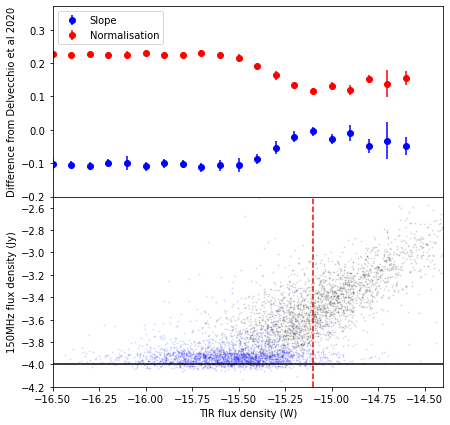

In [72]:
fig,axs = plt.subplots(2,1,sharex=True, gridspec_kw={'hspace': 0},figsize=[7,7])
axs[0].errorbar(lir_bins,m_diff,yerr=m_err,linestyle='',c='blue',marker='o',label='Slope')
axs[0].errorbar(lir_bins,c_diff,yerr=c_err,linestyle='',c='red',marker='o',label='Normalisation')
    
axs[0].set_ylabel('Difference from Delvecchio et al 2020')
axs[0].legend(loc='upper left')
axs[0].set_ylim(-0.2,0.37)



y = np.log10(limit_sample_en1['radio_flux_limit'])
x = np.log10(limit_sample_en1['TIR_flux'])
axs[1].scatter(x,y,alpha=0.1,s=1,c='blue') 

axs[1].hlines(-4,-16.5,-14.4,color='black')

y = np.log10(detected_sample_en1['Total_flux'])
x = np.log10(detected_sample_en1['TIR_flux'])
axs[1].scatter(x,y,alpha=0.1,s=1,c='black') 

axs[1].vlines(-15.1,-4.2,-2.5,color='red',linestyle='dashed')

axs[1].set_ylabel('150MHz flux density (Jy)')
axs[1].set_xlabel('TIR flux density (W)')

plt.xlim(-16.5,-14.4)
plt.ylim(-4.2,-2.5)

plt.savefig('plots/IR_lim_bias.pdf',format='pdf')
plt.show()

## Compute non-linearity of the FIRC based on what the main sequence would predict



There are 7645 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power


linear fit parameters: m = 0.90658 +\- 0.0053005, c = -9.917 +\- 0.20106
linear fit parameters: m = 0.83155 +\- 0.014517, c = -8.1613 +\- 0.54795
linear fit parameters: m = 0.81544 +\- 0.028362, c = -7.7916 +\- 1.0738


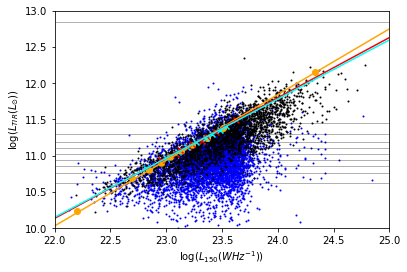

In [257]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

pred_SFR = main_sequnce_calc_schreiber2015(detected_data['Mstar_bayes']/3.8E26,detected_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_schreiber',data=pred_TIR)
detected_data.add_column(col_pred_TIR)


pred_SFR = main_sequnce_calc_schreiber2015(limit_data['Mstar_bayes']/3.8E26,limit_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_schreiber',data=pred_TIR)
limit_data.add_column(col_pred_TIR)

pred_SFR = main_sequence_calc_leslie2020(detected_data['Mstar_bayes']/3.8E26,detected_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_leslie',data=pred_TIR)
detected_data.add_column(col_pred_TIR)


pred_SFR = main_sequence_calc_leslie2020(limit_data['Mstar_bayes']/3.8E26,limit_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_leslie',data=pred_TIR)
limit_data.add_column(col_pred_TIR)


#mask_det = det.astype(bool)
x = np.log10(limit_data['radio_luminosity_limit'][::3])
y = np.log10(limit_data['Ldust_bayes'][::3]/3.8E26)
plt.scatter(x,y,s=1,c='blue')

x = np.log10(detected_data['radio_luminosity'][::3])
y = np.log10(detected_data['Ldust_bayes'][::3]/3.8E26)
plt.scatter(x,y,s=1,c='black')




ldusts = np.log10(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes']))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)





num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,xerr=xerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='orange')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')

hlines = np.array(bins_ldust) - np.log10(3.8E26)
plt.hlines(hlines,xmin=22,xmax=25,alpha=0.3,linewidth=1,color='black')




ldusts = np.log10(np.append(detected_data['pred_TIR_schreiber']*3.8E26,limit_data['pred_TIR_schreiber']*3.8E26))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)



num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
plt.scatter(x,y,c='red',marker='x')
plt.errorbar(x,y,xerr=xerr,c='red',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='red')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')



ldusts = np.log10(np.append(detected_data['pred_TIR_leslie']*3.8E26,limit_data['pred_TIR_leslie']*3.8E26))
bins_ldust = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_ldust.append(np.percentile(ldusts,percent))
bins_ldust = np.array(bins_ldust)



num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = np.log10(detected_data[ldust_name][bootstrap_det[n]])
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = np.log10(limit_data[ldust_name][bootstrap_lim[n]])

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(ldust_det,ldust_lim)
    


    test = np.digitize(redshifts,bins=bins_ldust)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_ldust)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_ldust))
    y = x - np.log10(3.75E12) - mean_q_agnfitter  
    mask = ~np.isinf(y)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=np.array(median_q_err)[mask])

    
    median_q.append(y)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

y = get_center(bins_ldust) - np.log10(3.8E26)
x = medians
xerr = errs
plt.scatter(x,y,c='cyan',marker='x')
plt.errorbar(x,y,xerr=xerr,c='cyan',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(22,25.5,0.1)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
#invert the linear fit int the y=x line to matc the other plots in the paper
y = linear_fit(x,1/m_mean,(c_mean*-1)/m_mean) - np.log10(3.8E26)
#y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='cyan')

print(f'linear fit parameters: m = {1/m_mean:2.5} +\- {m_std:2.5}, c = {(c_mean*-1)/m_mean - np.log10(3.8E26):2.5} +\- {c_std:2.5}')





plt.xlim(22,25)
plt.ylim(10,13)
plt.xlabel('$\log( L_{150}(W Hz^{-1}) )$')
plt.ylabel('$\log( L_{TIR}(L_{\odot}) )$')
plt.savefig('plots/FIRC_nonlinearity.pdf',format='pdf')
plt.show()

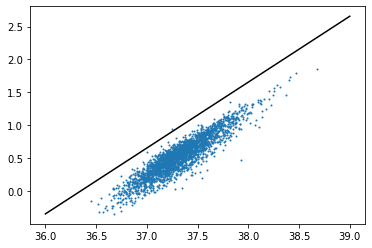

In [289]:
x = np.log10(detected_data['Ldust_bayes'])
y = np.log10(detected_data['SFR_bayes'])
plt.scatter(x,y,s=1)

x = np.arange(36,39,0.001)
y = 10**pred_SFR*(5.8E9)

y = x-np.log10(3.8E26) - np.log10(5.8E9)
plt.plot(x,y,c='black')

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power


power law fit parameters without correction: m = -0.22942 +\- 0.020638, c = 2.0572 +\- 0.0074891
power law fit parameters with correction: m = -0.11028 +\- 0.016643, c = 1.9839 +\- 0.0063143


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


power law fit parameters with correction: m = -0.11028 +\- 0.016643, c = 1.9839 +\- 0.0063143


power law fit parameters with correction: m = -0.64769 +\- 0.035329, c = 2.264 +\- 0.020458


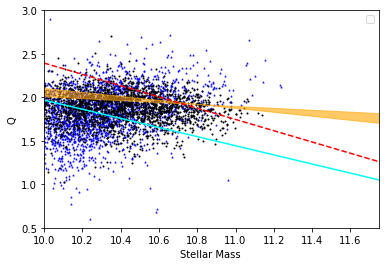

In [283]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

pred_SFR = main_sequnce_calc_schreiber2015(detected_data['Mstar_bayes']/3.8E26,detected_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_schreiber',data=pred_TIR)
detected_data.add_column(col_pred_TIR)
pred_q = np.log10(pred_TIR*3.8E26/3.75E12) - np.log10(detected_data['radio_luminosity'])
col_pred_q = Column(name='pred_q_schrieber',data=pred_q)
detected_data.add_column(col_pred_q)


pred_SFR = main_sequnce_calc_schreiber2015(limit_data['Mstar_bayes']/3.8E26,limit_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_schreiber',data=pred_TIR)
limit_data.add_column(col_pred_TIR)
pred_q = np.log10(pred_TIR*3.8E26/3.75E12) - np.log10(limit_data['radio_luminosity_limit'])
col_pred_q = Column(name='pred_qlim_schrieber',data=pred_q)
limit_data.add_column(col_pred_q)


pred_SFR = main_sequence_calc_leslie2020(detected_data['Mstar_bayes']/3.8E26,detected_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_leslie',data=pred_TIR)
detected_data.add_column(col_pred_TIR)
pred_q = np.log10(pred_TIR*3.8E26/3.75E12) - np.log10(detected_data['radio_luminosity'])
col_pred_q = Column(name='pred_q_leslie',data=pred_q)
detected_data.add_column(col_pred_q)


pred_SFR = main_sequence_calc_leslie2020(limit_data['Mstar_bayes']/3.8E26,limit_data['Z_BEST'])
pred_TIR = 10**pred_SFR*(5.8E9)
col_pred_TIR = Column(name='pred_TIR_leslie',data=pred_TIR)
limit_data.add_column(col_pred_TIR)
pred_q = np.log10(pred_TIR*3.8E26/3.75E12) - np.log10(limit_data['radio_luminosity_limit'])
col_pred_q = Column(name='pred_qlim_leslie',data=pred_q)
limit_data.add_column(col_pred_q)



mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

mask_det = det.astype(bool)
x = limit_data['Mass_median']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Mass_median']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')





redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
#plt.scatter(x,y,c='orange',label='SF only')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y_uncorr = linear_fit(x,m_mean,c_mean)
#plt.plot(x+10.2,y_uncorr,c='orange')
#y = linear_fit(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')

print(f'power law fit parameters without correction: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')




    
num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr_kmf = abs(fit_func(ratios,correction_fit_mass[0],correction_fit_mass[1],0) - fit_func(5,correction_fit_mass[0],correction_fit_mass[1],0))
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask] - yerr_kmf,sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
#plt.scatter(x,y,c='orange',label='SF only')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean_corr = np.mean(popts[:,0])
m_std_corr = np.std(popts[:,0])
c_mean_corr = np.mean(popts[:,1])
c_std_corr = np.std(popts[:,1])
y_corr = linear_fit(x,m_mean_corr,c_mean_corr)
#plt.plot(x+10.2,y_corr,c='orange')
#y = linear_fit(x,m_mean+m_std,c_mean)
#plt.plot(x+10.2,y,c='orange',linestyle='dashed')


plt.fill_between(x+10.2,y_uncorr,y_corr,color='orange',alpha=0.6)

print(f'power law fit parameters with correction: m = {m_mean_corr:2.5} +\- {m_std_corr:2.5}, c = {c_mean_corr:2.5} +\- {c_std_corr:2.5}')



det_name = 'pred_q_leslie'
lim_name = 'pred_qlim_leslie'

num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr_kmf = abs(fit_func(ratios,correction_fit_mass[0],correction_fit_mass[1],0) - fit_func(5,correction_fit_mass[0],correction_fit_mass[1],0))
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs

yerr_kmf = abs(fit_func(ratios,1.08425517,13.09130498,0) - fit_func(5,1.08425517,13.09130498,0))
yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
#plt.scatter(x,y,c='orange',label='SF only')
#plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x+10.2,y,c='cyan',linestyle='solid')

print(f'power law fit parameters with correction: m = {m_mean_corr:2.5} +\- {m_std_corr:2.5}, c = {c_mean_corr:2.5} +\- {c_std_corr:2.5}')



det_name = 'pred_q_schrieber'
lim_name = 'pred_qlim_schrieber'

num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
corrections_survival = np.array([])
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    ratios = np.array([])
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])
        ratios = np.append(ratios,np.sum(det[mask].astype(bool))/np.sum(~det[mask].astype(bool)))


        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr_boot = np.array(median_q_err)
    yerr_kmf = abs(fit_func(ratios,correction_fit_mass[0],correction_fit_mass[1],0) - fit_func(5,correction_fit_mass[0],correction_fit_mass[1],0))
    yerr = np.sqrt(yerr_boot**2)# + yerr_kmf**2)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    corrections_survival = np.append(corrections_survival,yerr_kmf)

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr_boot = errs


x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y = linear_fit(x,m_mean,c_mean)

plt.plot(x+10.2,y,c='red',linestyle='dashed')

print(f'power law fit parameters with correction: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')



plt.xlim(10.0,11.75)
plt.ylim(0.5,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend(ncol=2)
plt.savefig('plots/FIRC_mstar_evo_corr.pdf',format='pdf')
plt.show()

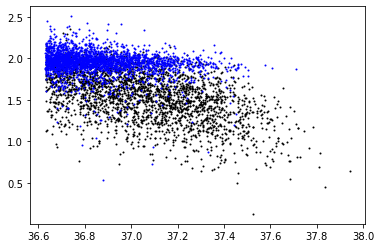

In [286]:
x = np.log10(detected_data['Mstar_bayes'])
y = detected_data['pred_q_leslie']
plt.scatter(x,y,s=1,c='black')

x = np.log10(limit_data['Mstar_bayes'])
y = limit_data['pred_qlim_leslie']
plt.scatter(x,y,s=1,c='blue')

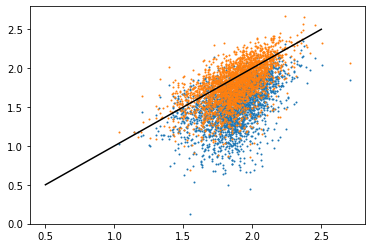

In [282]:
x = detected_data['q_magphys']
y = detected_data['pred_q_leslie']
plt.scatter(x,y,s=1)

x = detected_data['q_magphys']
y = detected_data['pred_q_schrieber']
plt.scatter(x,y,s=1)
plt.plot([0.5,2.5],[0.5,2.5],c='black')
plt.show()

## Calculate the bias introduced in the median q of the high mass bin for our mass evolution sample

There are 519 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 97 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


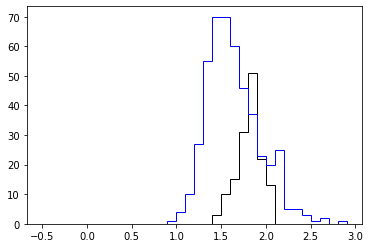

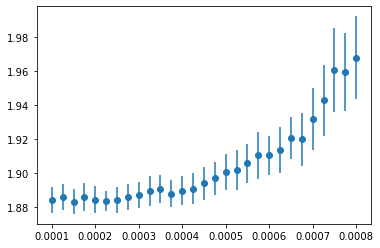

[  1.95737776 119.10019077   1.88407945]


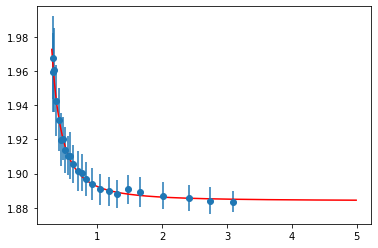

In [109]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#select sources from teh mass evolution sample but only look at M>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.7)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.7)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]







flims = np.arange(100,801,25)*1E-6
spectral_index = -0.63

dist = cosmo.luminosity_distance(detected_data['Z_BEST']).to(u.m).value

medians = []
errs = []
ratio = []
for m,flim in enumerate(flims):
    mask_det = detected_data['Total_flux']>flim
    q_det = detected_data[det_name][mask_det]
    
    
    z = detected_data['Z_BEST'][~mask_det]
    #lrad_lims = flim*(4*np.pi*dist[~mask_det]**2 * (1+z)**(-1-spectral_index)) * 1E26
    lrad_lims = flim*4*np.pi*dist[~mask_det]**2 * 1E-26 * (1+z)**(-1-spectral_index)
    
    new_q_lims = np.log10(detected_data['Ldust_bayes'][~mask_det]/3.75E12) - np.log10(lrad_lims)
    q_lim = np.append(new_q_lims,limit_data[lim_name])
    
    ratio.append(len(q_det)/len(q_lim))

    
    num = 100
    N = int(len(q_det)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
    N = int(len(q_lim)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)
    
    median_q = []
    for n in range(num):
        data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))


        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        median_q.append(kmf.median_survival_time_)



    median_q = np.array(median_q)

    medians.append(np.mean(median_q))
    errs.append(np.std(median_q))

    
bins=np.arange(-0.5,3.0,0.1)
y = q_det
plt.hist(y,bins=bins,histtype='step',color='black')
y = q_lim
plt.hist(y,bins=bins,histtype='step',color='blue')
plt.show()

x = flims
y = medians
plt.errorbar(x,y,yerr=errs,linestyle='',marker='o')
plt.show()

mask = np.array(ratio)<3.5
x = np.array(ratio)[mask]
y = np.array(medians)[mask]
plt.errorbar(x,y,yerr=np.array(errs)[mask],linestyle='',marker='o')

popt,pcov = curve_fit(fit_func,x,y,sigma=np.array(errs)[mask])
print(popt)
x = np.arange(0.3,5,0.01)
y = fit_func(x,popt[0],popt[1],popt[2])
plt.plot(x,y,c='red')
plt.show()









In [ ]:
mask = np.array(ratio)<3.5
x = np.array(ratio)[mask]
y = np.array(medians)[mask]
plt.errorbar(x,y,yerr=np.array(errs)[mask],linestyle='',marker='o')

popt,pcov = curve_fit(fit_func,x,y,sigma=np.array(errs)[mask])
print(popt)
x = np.arange(0.3,5,0.01)
y = fit_func(x,popt[0],popt[1],popt[2])
plt.plot(x,y,c='red')
plt.show()

In [ ]:
fit_func(5,popt[0],popt[1],popt[2])

In [ ]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#select sources from teh mass evolution sample but only look at M>10.7
mass_bins = np.array([ 10.21095837, 10.26660685,
       10.33486441, 10.40830882, 10.49441073, 10.59295694, 10.73084296,
       11.36323973])

popts = np.array([])
pcovs = np.array([])
for i in range(len(mass_bins)-1):

    mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>mass_bins[i]) & (mstar<mass_bins[i+1])# & mask_loc
    agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
    SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
    detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
    print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


    mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>mass_bins[i]) & (mstar<mass_bins[i+1])# & mask_loc
    SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
    limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


    mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
    detected_data = detected_data[mask]

    mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
    limit_data = limit_data[mask]







    flims = np.arange(100,801,25)*1E-6
    spectral_index = -0.63

    dist = cosmo.luminosity_distance(detected_data['Z_BEST']).to(u.m).value


    medians = []
    errs = []
    ratio = []
    for m,flim in enumerate(flims):
        mask_det = detected_data['Total_flux']>flim
        q_det = detected_data[det_name][mask_det]


        z = detected_data['Z_BEST'][~mask_det]
        #lrad_lims = flim*(4*np.pi*dist[~mask_det]**2 * (1+z)**(-1-spectral_index)) * 1E26
        lrad_lims = flim*4*np.pi*dist[~mask_det]**2 * 1E-26 * (1+z)**(-1-spectral_index)

        new_q_lims = np.log10(detected_data['Ldust_bayes'][~mask_det]/3.75E12) - np.log10(lrad_lims)
        q_lim = np.append(new_q_lims,limit_data[lim_name])

        ratio.append(len(q_det)/len(q_lim))


        num = 100
        N = int(len(q_det)*0.9)
        bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
        N = int(len(q_lim)*0.9)
        bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

        median_q = []
        for n in range(num):
            data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
            #data[flag_detected] = q_lim[flag_detected]
            det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))


            kmf = KaplanMeierFitter() 

            ## Fit the data into the model
            kmf.fit(data, det,label='Kaplan Meier Estimate')

            median_q.append(kmf.median_survival_time_)



        median_q = np.array(median_q)

        medians.append(np.mean(median_q))
        errs.append(np.std(median_q))


    '''bins=np.arange(-0.5,3.0,0.1)
    y = q_det
    plt.hist(y,bins=bins,histtype='step',color='black')
    y = q_lim
    plt.hist(y,bins=bins,histtype='step',color='blue')
    plt.show()

    x = flims
    y = medians
    plt.errorbar(x,y,yerr=errs,linestyle='',marker='o')
    plt.show()'''



    mask = ~np.isinf(medians)
    x = np.array(ratio)[mask]
    y = np.array(medians)[mask]
    sigma = np.array(errs)[mask]
    #plt.errorbar(x,y,yerr=sigma,linestyle='',marker='o')

    popt,pcov = curve_fit(fit_func,x,y,sigma=sigma)
    print(popt)
    #x = np.arange(0.25,5,0.01)
    #y = fit_func(x,popt[0],popt[1],popt[2])
    #plt.plot(x,y,c='red')
    #plt.show()

    #print(fit_func(0.3,popt[0],popt[1],popt[2]) - fit_func(5,popt[0],popt[1],popt[2]))
    popts = np.append(popts,popt)
    pcovs = np.append(pcovs,pcov)
    

popts = popts.reshape(len(mass_bins)-1,3)
    
x = get_center(mass_bins)
y = popts[:,0]
plt.scatter(x,y)
plt.show()

x = get_center(mass_bins)
y = popts[:,1]
plt.scatter(x,y)
plt.show()







In [ ]:
popts = popts.reshape(len(mass_bins)-1,3)
    
x = get_center(mass_bins)
y = popts[:,0]
plt.scatter(x,y)
plt.show()

x = get_center(mass_bins)
y = popts[:,1]
plt.scatter(x,y)
plt.show()

In [ ]:
bins_z

In [ ]:
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05) & (mstar<10.1)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05) & (mstar<10.1)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

print(len(detected_data)/len(limit_data))

In [ ]:
flims

## Check that the results agree when compared to stacking

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


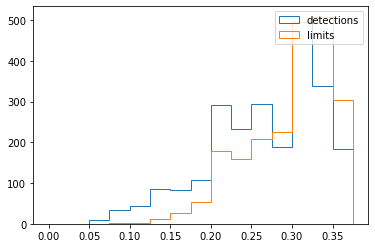

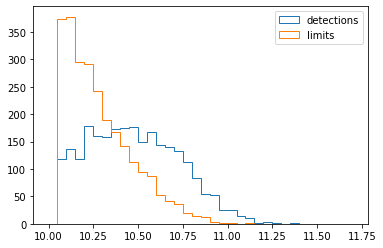

[10.04906876 10.10162295 10.15076618 10.21079898 10.26606192 10.33428926
 10.40752616 10.49327508 10.59167135 10.72948352 11.36323973]
power law fit parameters: m = -0.23008 +\- 0.017248, N = 2.0586 +\- 0.0073527


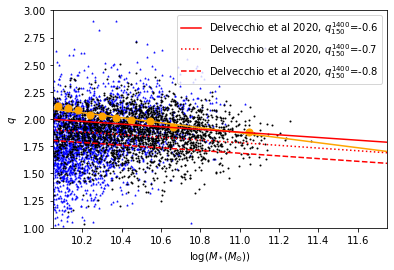

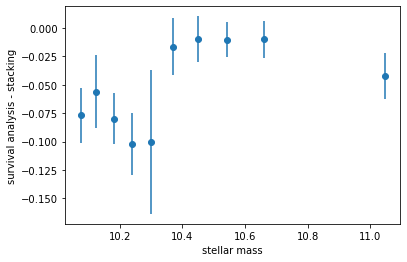

In [81]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

bins = np.arange(0,0.4,0.025)
y = detected_data['Z_BEST']
plt.hist(y,bins=bins,histtype='step',label='detections')
y = limit_data['Z_BEST']
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()

bins = np.arange(10,11.75,0.05)
y = np.log10(detected_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='detections')
y = np.log10(limit_data['Mstar_bayes']/3.8E26)
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()


x = np.log10(limit_data['Mstar_bayes']/3.8E26)
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = np.log10(detected_data['Mstar_bayes']/3.8E26)
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')




redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(linear_fit,x[mask]-10.2,y[mask],sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',s=50)
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(-1,2,0.001)
m_mean = np.mean(popts[:,0])
m_std = np.std(popts[:,0])
c_mean = np.mean(popts[:,1])
c_std = np.std(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x+10.2,y,c='orange')

print(f'power law fit parameters: m = {m_mean:2.5} +\- {m_std:2.5}, N = {c_mean:2.5} +\- {c_std:2.5}')

    
                      
#plt.scatter(x,y,c='green')



x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.6))
plt.plot(x,y,c='red',linestyle='solid',label='Delvecchio et al 2020, $q^{1400}_{150}$=-0.6')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.7))
plt.plot(x,y,c='red',linestyle='dotted',label='Delvecchio et al 2020, $q^{1400}_{150}$=-0.7')
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.8))
plt.plot(x,y,c='red',linestyle='dashed',label='Delvecchio et al 2020, $q^{1400}_{150}$=-0.8')

#plt.scatter()


plt.xlim(10.05,11.75)
plt.ylim(1,3)
plt.xlabel('$\log( M_*(M_{\odot}) )$ ')
plt.ylabel('$q$')
plt.legend()
plt.savefig('plots/FIRC_mstar_evo_linear.pdf',format='pdf')
plt.show()


masses = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
qs = np.append(detected_data['radio_flux_pixel'],limit_data['radio_flux_pixel'])

num = 100
N = int(len(qs)*1.0)
bootstrap_num = bootstrap(np.arange(0,len(qs),1),num,samples=N).astype(int)

avg_qs_stacking = np.array([])
for m,boot in enumerate(bootstrap_num):
    avg_fluxes_measured,_,_ = scipy.stats.binned_statistic(masses[boot],qs[boot],bins=bins_z,statistic='median')


    #calculate the average flux for each mass bin assuming all sources have the median q
    
    for n in range(len(bins_z) -1):
        alpha=-0.6

        mask = (masses[boot]>bins_z[n]) & (masses[boot]<bins_z[n+1])
        redshift = np.median(np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])[boot][mask])
        dist = cosmo.luminosity_distance(redshift).to(u.m).value
        rad_lum = avg_fluxes_measured[n]*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)
        fir_lums = np.median(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes'])[boot][mask])
        q = np.log10(fir_lums/3.75E12) - np.log10(rad_lum)

        if (rad_lum<0):()
            #print('found nan')
        
        avg_qs_stacking = np.append(avg_qs_stacking,q)

avg_qs_stacking = avg_qs_stacking.reshape(num,len(bins_z)-1)

x = get_center(bins_z)
y = medians - np.nanmedian(avg_qs_stacking,axis=0)
yerr = np.nanstd(avg_qs_stacking,axis=0)
plt.errorbar(x,y,yerr=yerr,linestyle='',marker='o')
plt.xlabel('stellar mass')
plt.ylabel('survival analysis - stacking')
plt.show()

[4.37900017e-05 5.03934134e-05 5.86442220e-05 7.40705655e-05
 7.92852807e-05 1.19537683e-04 1.45649596e-04 1.69139690e-04
 2.28369812e-04 3.55996570e-04]
[6.59918946e-05 7.12627961e-05 8.34581178e-05 1.08527790e-04
 1.13993936e-04 1.45590044e-04 1.71026578e-04 2.03527951e-04
 2.66850526e-04 4.23027410e-04]


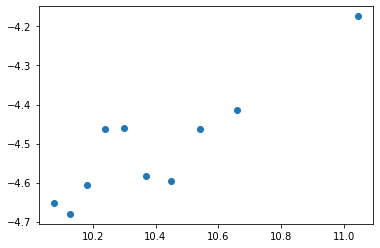

In [82]:
masses = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
qs = np.append(detected_data['radio_flux_pixel'],limit_data['radio_flux_pixel'])


avg_fluxes_measured,_,_ = scipy.stats.binned_statistic(masses,qs,bins=bins_z,statistic='median')
print(avg_fluxes_measured)

#calculate the average flux for each mass bin assuming all sources have the median q
avg_fluxes_survival = np.array([])
for n in range(len(bins_z) -1):
    alpha=-0.6
    mstar = np.append( np.log10(detected_data['Mstar_bayes']/3.8E26), np.log10(limit_data['Mstar_bayes']/3.8E26) )
    mask = (mstar>bins_z[n]) & (mstar<bins_z[n+1])
    redshift = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])[mask]
    dist = cosmo.luminosity_distance(redshift).to(u.m).value
    q = medians[n]
    fir_lums = np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes'])[mask]
    rad_lum = 10**(np.log10(fir_lums/3.75E12) - q)
    fluxes = rad_lum/(4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha))
    
    avg_fluxes_survival = np.append(avg_fluxes_survival,np.median(fluxes))
    
print(avg_fluxes_survival)
x = get_center(bins_z)
y = np.log10(avg_fluxes_survival - avg_fluxes_measured)
plt.scatter(x,y)
plt.show()

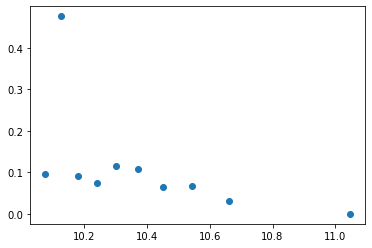

In [193]:
masses = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
qs = np.append(detected_data['radio_flux_pixel'],limit_data['radio_flux_pixel'])


avg_fluxes_measured,_,_ = scipy.stats.binned_statistic(masses,qs,bins=bins_z,statistic='mean')


#calculate the average flux for each mass bin assuming all sources have the median q
avg_qs_stacking = np.array([])
for n in range(len(bins_z) -1):
    alpha=-0.6

    mask = (masses>bins_z[n]) & (masses<bins_z[n+1])
    redshift = np.mean(np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])[mask])
    dist = cosmo.luminosity_distance(redshift).to(u.m).value
    rad_lum = avg_fluxes_measured[n]*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)
    fir_lums = np.mean(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes'])[mask])
    q = np.log10(fir_lums/3.75E12) - np.log10(rad_lum)


    avg_qs_stacking = np.append(avg_qs_stacking,q)



x = get_center(bins_z)
y = medians - avg_qs_stacking

plt.scatter(x,y)
plt.show()

In [84]:
avg_qs_stacking

array([2.19307937, 2.15805835, 2.16273782, 2.13593912, 2.11981808,
       2.03660974, 1.99563601, 1.9972341 , 1.93883597, 1.92773188])

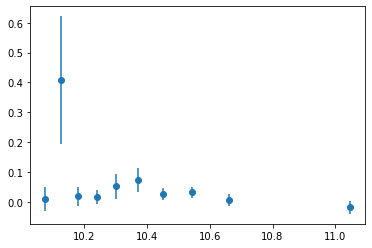

In [211]:
masses = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
qs = np.append(detected_data['radio_flux_pixel'],limit_data['radio_flux_pixel']) - np.nanmean(radim_data)

num = 100
N = int(len(qs)*0.9)
bootstrap_num = bootstrap(np.arange(0,len(qs),1),num,samples=N).astype(int)

avg_qs_stacking = np.array([])
for m,boot in enumerate(bootstrap_num):
    avg_fluxes_measured,_,_ = scipy.stats.binned_statistic(masses[boot],qs[boot],bins=bins_z,statistic='mean')


    #calculate the average flux for each mass bin assuming all sources have the median q
    
    for n in range(len(bins_z) -1):
        alpha=-0.6

        mask = (masses[boot]>bins_z[n]) & (masses[boot]<bins_z[n+1])
        redshift = np.mean(np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])[boot][mask])
        dist = cosmo.luminosity_distance(redshift).to(u.m).value
        rad_lum = avg_fluxes_measured[n]*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)
        fir_lums = np.mean(np.append(detected_data['Ldust_bayes'],limit_data['Ldust_bayes'])[boot][mask])
        q = np.log10(fir_lums/3.75E12) - np.log10(rad_lum)

        if (rad_lum<0):()
            #print('found nan')
        
        avg_qs_stacking = np.append(avg_qs_stacking,q)

avg_qs_stacking = avg_qs_stacking.reshape(num,len(bins_z)-1)
qs_stacking = np.nanmedian(avg_qs_stacking,axis=0)

x = get_center(bins_z)
y = medians - qs_stacking
qs_stacking_err = np.nanstd(avg_qs_stacking,axis=0)
plt.errorbar(x,y,yerr=qs_stacking_err,linestyle='',marker='o')
plt.show()

In [207]:
qs_stacking

array([2.10221765, 1.66019213, 2.07796293, 2.01938309, 1.95979336,
       1.95507905, 1.97066992, 1.95322223, 1.92209235, 1.89643125])

## Copy the method used in Smith et al 2021 to calculate the PDF of each source in the q vs Mstar plane

In [91]:
#Read in the LOFAR and HERschel maps
fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header).celestial
radim_err = hdulist[0].data[0][0]
hdulist.close()

  'HZ' -> 'Hz'. [astropy.wcs.wcs]


In [92]:
lofar_magphys_en1[0]

ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim,q_250_lim,q_350_lim,q_500_lim,TIR_flux
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,ma

There are 2513 galaxies detected in the radio with a stellar mass>10.7 and z<1
0
0
There are 2569 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


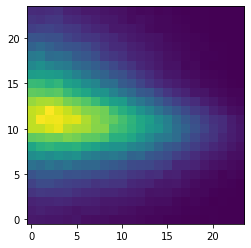

In [171]:
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))


dist = cosmo.luminosity_distance(detected_data['Z_BEST']).to(u.m).value
masses = np.array([])
sfrs = np.array([])
qs = np.array([])
rad_lums = np.array([])
N = 100
for n in range(len(detected_data)):
    
    
    mass_mean = detected_data['Mstar_50'][n]/3.8E26
    mass_err = (detected_data['Mstar_84'][n] - detected_data['Mstar_16'][n])/3.8E26
    mass_samples = scipy.stats.norm.rvs(mass_mean,mass_err,size=N)
    
    
    flux_mean = detected_data['Total_flux'][n]
    flux_err = detected_data['E_Total_flux'][n]
    flux_samples = scipy.stats.norm.rvs(flux_mean,flux_err,size=N)
    
    lum_samples = flux_samples*4*np.pi*dist[n]**2 * 1E-26 * (1+detected_data['Z_BEST'][n])**(-1-alpha)
    mask = lum_samples<1E17
    lum_samples[mask] = 1E17
    rad_lums = np.append(rad_lums,lum_samples)
    
    fir_mean = detected_data['Ldust_50'][n]
    fir_err = detected_data['Ldust_84'][n] - detected_data['Ldust_16'][n]
    fir_samples = scipy.stats.norm.rvs(fir_mean,fir_err,size=N)
    mask = fir_samples<1E6
    fir_samples[mask] = 1E6

    
    q_samples = np.log10(fir_samples/3.75E12) - np.log10(lum_samples)
    
    qs = np.append(qs,q_samples)
    masses = np.append(masses,mass_samples)
    
print(np.sum(rad_lums<1E17))
print(np.sum(np.isnan(qs)))
mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (mstar>10.05)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))

dist = cosmo.luminosity_distance(limit_data['Z_BEST']).to(u.m).value
for n in range(len(limit_data)):
    
    mass_mean = limit_data['Mstar_50'][n]/3.8E26
    mass_err = (limit_data['Mstar_84'][n] - limit_data['Mstar_16'][n])/3.8E26
    mass_samples = scipy.stats.norm.rvs(mass_mean,mass_err,size=N)
    
    flux_mean = limit_data['radio_flux_pixel'][n]
    flux_err = limit_data['radio_flux_limit'][n]/5
    flux_samples = scipy.stats.norm.rvs(flux_mean,flux_err,size=N)
    
    lum_samples = flux_samples*4*np.pi*dist[n]**2 * 1E-26 * (1+limit_data['Z_BEST'][n])**(-1-alpha)
    mask = lum_samples<1E17
    lum_samples[mask] = 1E17
    rad_lums = np.append(rad_lums,lum_samples)
    
    fir_mean = limit_data['Ldust_50'][n]
    fir_err = limit_data['Ldust_84'][n] - limit_data['Ldust_16'][n]
    fir_samples = scipy.stats.norm.rvs(fir_mean,fir_err,size=N)
    mask = fir_samples<1E7
    fir_samples[mask] = 1E7
    
    q_samples = np.log10(fir_samples/3.75E12) - np.log10(lum_samples)
    
    qs = np.append(qs,q_samples)
    masses = np.append(masses,mass_samples)
    
    
mass_bins = np.linspace(10.2,11.2,25)
q_bins = np.linspace(1,3,25)
data,_,_ = np.histogram2d(np.log10(masses),qs,bins=[mass_bins,q_bins])


plt.imshow(data.transpose())
plt.gca().invert_yaxis()
plt.show()

    

In [173]:
qs_smith,_,_ = scipy.stats.binned_statistic(np.log10(masses),qs,bins=bins_z,statistic='median')

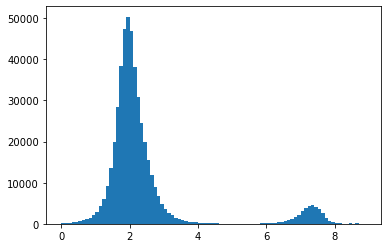

2.013435182538263


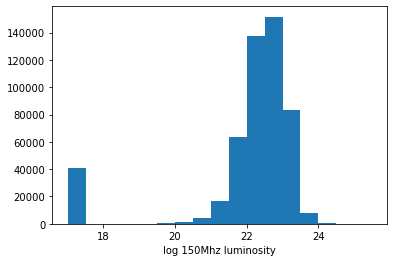

22.466888618254046


In [96]:
plt.hist(qs,bins=np.arange(0,9,0.1))
plt.show()
print(np.nanmedian(qs))

plt.hist(np.log10(rad_lums),bins=np.arange(17,26,0.5))
plt.xlabel('log 150Mhz luminosity')
plt.show()

print(np.median(np.log10(rad_lums)))

Text(0, 0.5, 'q')

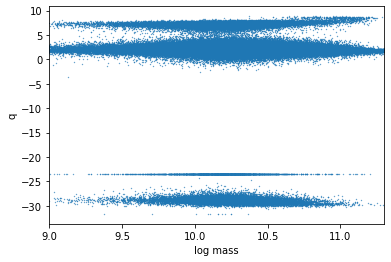

In [97]:
plt.scatter(np.log10(masses),qs,s=0.1)
plt.xlabel('log mass')
plt.xlim(9,11.3)
plt.ylabel('q')

(array([ 245.,    4.,   26.,  104.,  655., 1364.,  136.,   29.,    4.,
           2.]),
 array([-7.563139 , -6.9531302, -6.3431215, -5.7331133, -5.1231046,
        -4.513096 , -3.9030871, -3.2930784, -2.68307  , -2.0730612,
        -1.4630526], dtype=float32),
 <BarContainer object of 10 artists>)

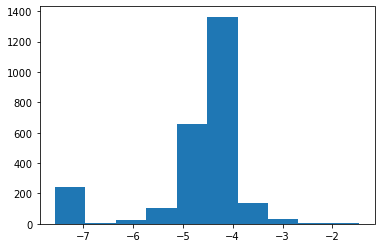

In [103]:
y = limit_data['radio_flux_pixel']
mask = y<0
y[mask] = 1E-7
plt.hist(np.log10(y))


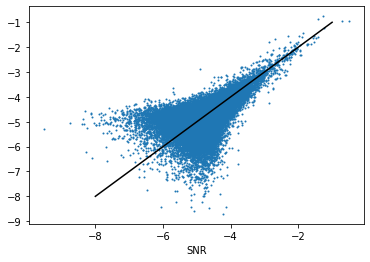

In [104]:
#Calculate upper limits on the radio flux from the LOFAR image for the HELP objects
ras = lofar_magphys_en1['RA']
decs = lofar_magphys_en1['DEC']

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,1,ra_dec_order=True),0).astype(int)
rad_flux_1 = radim_data[x,y]

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_flux_0 = radim_data[x,y]

plt.scatter(np.log10(rad_flux_1),np.log10(rad_flux_0),s=1)

plt.plot([-8,-1],[-8,-1],c='black')
plt.xlabel('SNR')
plt.show()


In [105]:
from herschelhelp import image_plotting,utils

239.98990167026162 55.01456045936245
0.00031148503


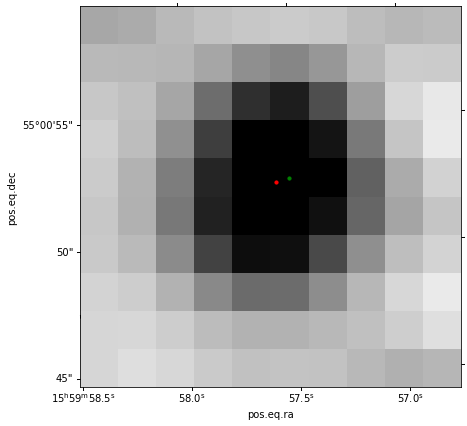

In [106]:
ras = lofar_sed_en1['RA']
decs = lofar_sed_en1['DEC']
print(ras[0],decs[0])
x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
print(radim_data[y[0],x[0]])

plot_params = {'marker':['o','+','o','v','X','d'],
              'col':['green','cyan','orange','red'],
              'size':100,
              'box_length':1/120,
              'use_redshift':[False,False,False,False]}
box_length = 1/240
fig = plt.figure(figsize=[7,7])
wcsplot,axs = image_plotting.image_plot(radim_data,ras[0],decs[0],radim_wcs,box_length,fig)
image_plotting.cat_plot(ras[0],decs[0],wcsplot,axs,marker='o')

ra,dec = radim_wcs.wcs_pix2world(x[0],y[0],0,ra_dec_order=True)
image_plotting.cat_plot(ra,dec,wcsplot,axs,marker='o',col='green')
plt.show()

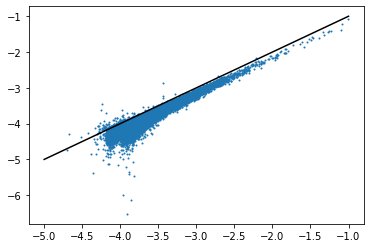

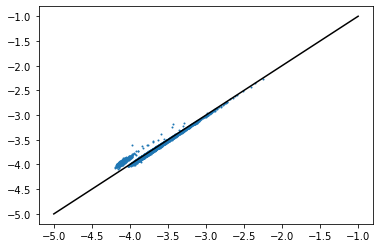

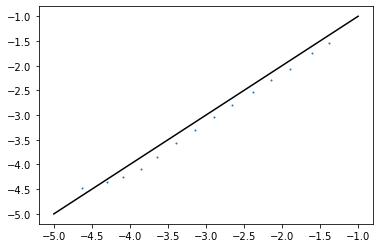

In [107]:
mask = lofar_sed_en1['S_Code']=='S'
ras = lofar_sed_en1['RA'][mask]
decs = lofar_sed_en1['DEC'][mask]

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,1,ra_dec_order=True),0).astype(int)
fluxes = radim_data[y,x] - np.nanmean(radim_data)

x = np.log10(lofar_sed_en1['Peak_flux'][mask])
y = np.log10(fluxes)
plt.scatter(x,y,s=1)
plt.plot([-5,-1],[-5,-1],c='black')

plt.show()

mask = (lofar_sed_en1['S_Code']=='S') & ((lofar_sed_en1['Total_flux'] - lofar_sed_en1['Peak_flux'])<2E-5)
ras = lofar_sed_en1['RA'][mask]
decs = lofar_sed_en1['DEC'][mask]

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,1,ra_dec_order=True),0).astype(int)
fluxes = radim_data[y,x] - np.nanmean(radim_data)

x = np.log10(lofar_sed_en1['Peak_flux'][mask])
y = np.log10(lofar_sed_en1['radio_flux_pixel'][mask])
plt.scatter(x,y,s=1)
plt.plot([-5,-1],[-5,-1],c='black')
plt.show()



mask = lofar_sed_en1['S_Code']=='S'
ras = lofar_sed_en1['RA'][mask]
decs = lofar_sed_en1['DEC'][mask]

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,1,ra_dec_order=True),0).astype(int)
fluxes = radim_data[y,x] - np.nanmean(radim_data)

x,_,_ = binned_statistic(np.log10(lofar_sed_en1['Peak_flux'][mask]),np.log10(lofar_sed_en1['Peak_flux'][mask]),bins=np.arange(-5,-1,0.25),statistic=np.nanmean)
y,_,_ = binned_statistic(np.log10(lofar_sed_en1['Peak_flux'][mask]),np.log10(fluxes),bins=np.arange(-5,-1,0.25),statistic=np.nanmean)
plt.scatter(x,y,s=1)
plt.plot([-5,-1],[-5,-1],c='black')

plt.show()